# Datenanalyse für einen Versuch zur Totalenergiekompensation von Variometern für Segelflugzeuge

In [13]:
from math import sqrt
import pandas as pd
import gpxpy

from pltgraph import *
%config InlineBackend.figure_format = 'jpg'
# Druckdaten vom OpenVario importieren
df = pd.read_csv("Messungen/erster.csv", parse_dates=True)

#Auf relevanten Bereich zuschneiden
lower = 2750 
upper = 3100

time = df["TIME"].to_list()
tek = df["TEK"].to_list()
static = df["STATIC"].to_list()
stau = df["STAU"].to_list()

time = [t-time[0] for t in time]

#Werte glätten
static = smoothListGaussian(static, 10)
tek = smoothListGaussian(tek, 10)

# GPS Daten importieren
gpx_file = open('Messungen/gps/20230419-175548 - Erster.gpx', 'r')
gpx = gpxpy.parse(gpx_file)

lower_gps = 527 
upper_gps = 579 

elev = 300 #Höhe des Flugplatzes (eigentlich ca. 250m aber GPS hat 300 gemessen)

time_gps = [point.time.timestamp() for point in gpx.tracks[0].segments[0].points]
speed_gps = [point.speed for point in gpx.tracks[0].segments[0].points]
altitude_gps = [point.elevation -elev for point in gpx.tracks[0].segments[0].points]

time_gps = [t-time_gps[0] for t in time_gps]

altitude_gps = smoothListGaussian(altitude_gps,5)
speed_gps = smoothListGaussian(speed_gps,5)


## Druckdaten

Statischer und TEK-Druck darstellen

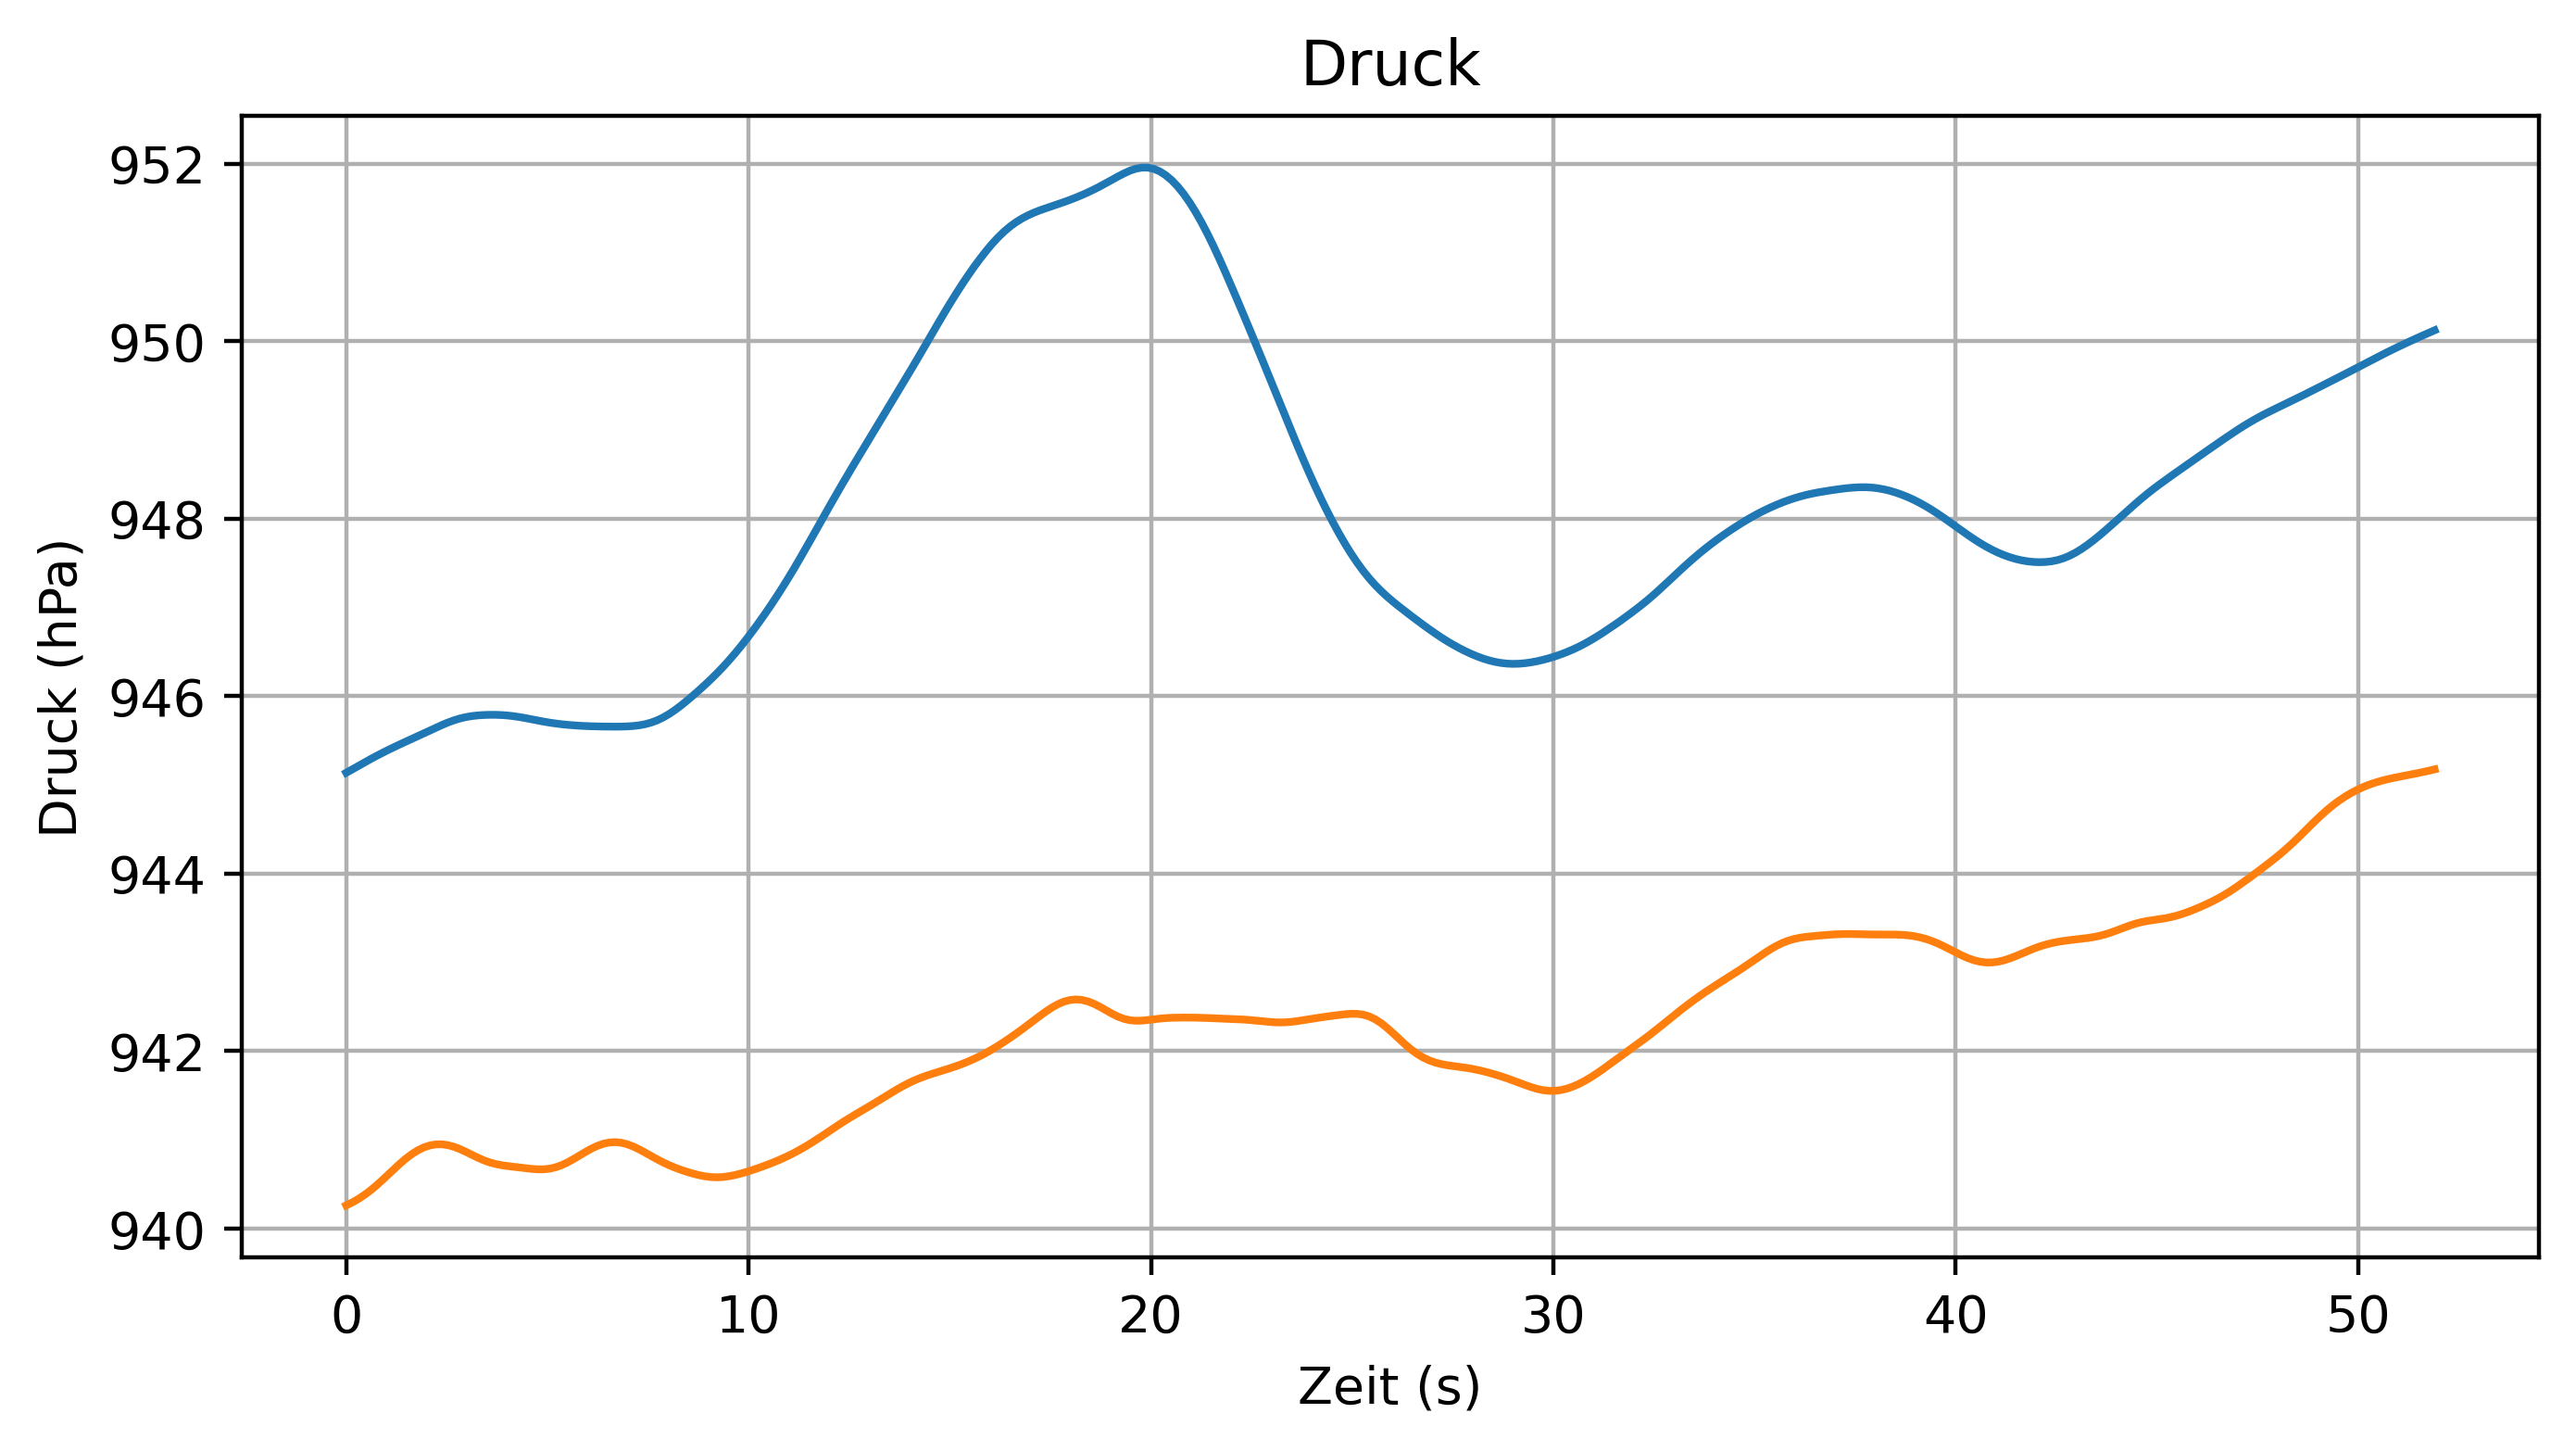

In [14]:
description = {
    "title": "Druck",
    "xLable": "Zeit (s)",
    "yLable": "Druck (hPa)"
}
plt_data(time,(static, tek), description=description, borders = (lower, upper), zerotime = True)

Druck in Höhe umrechnen

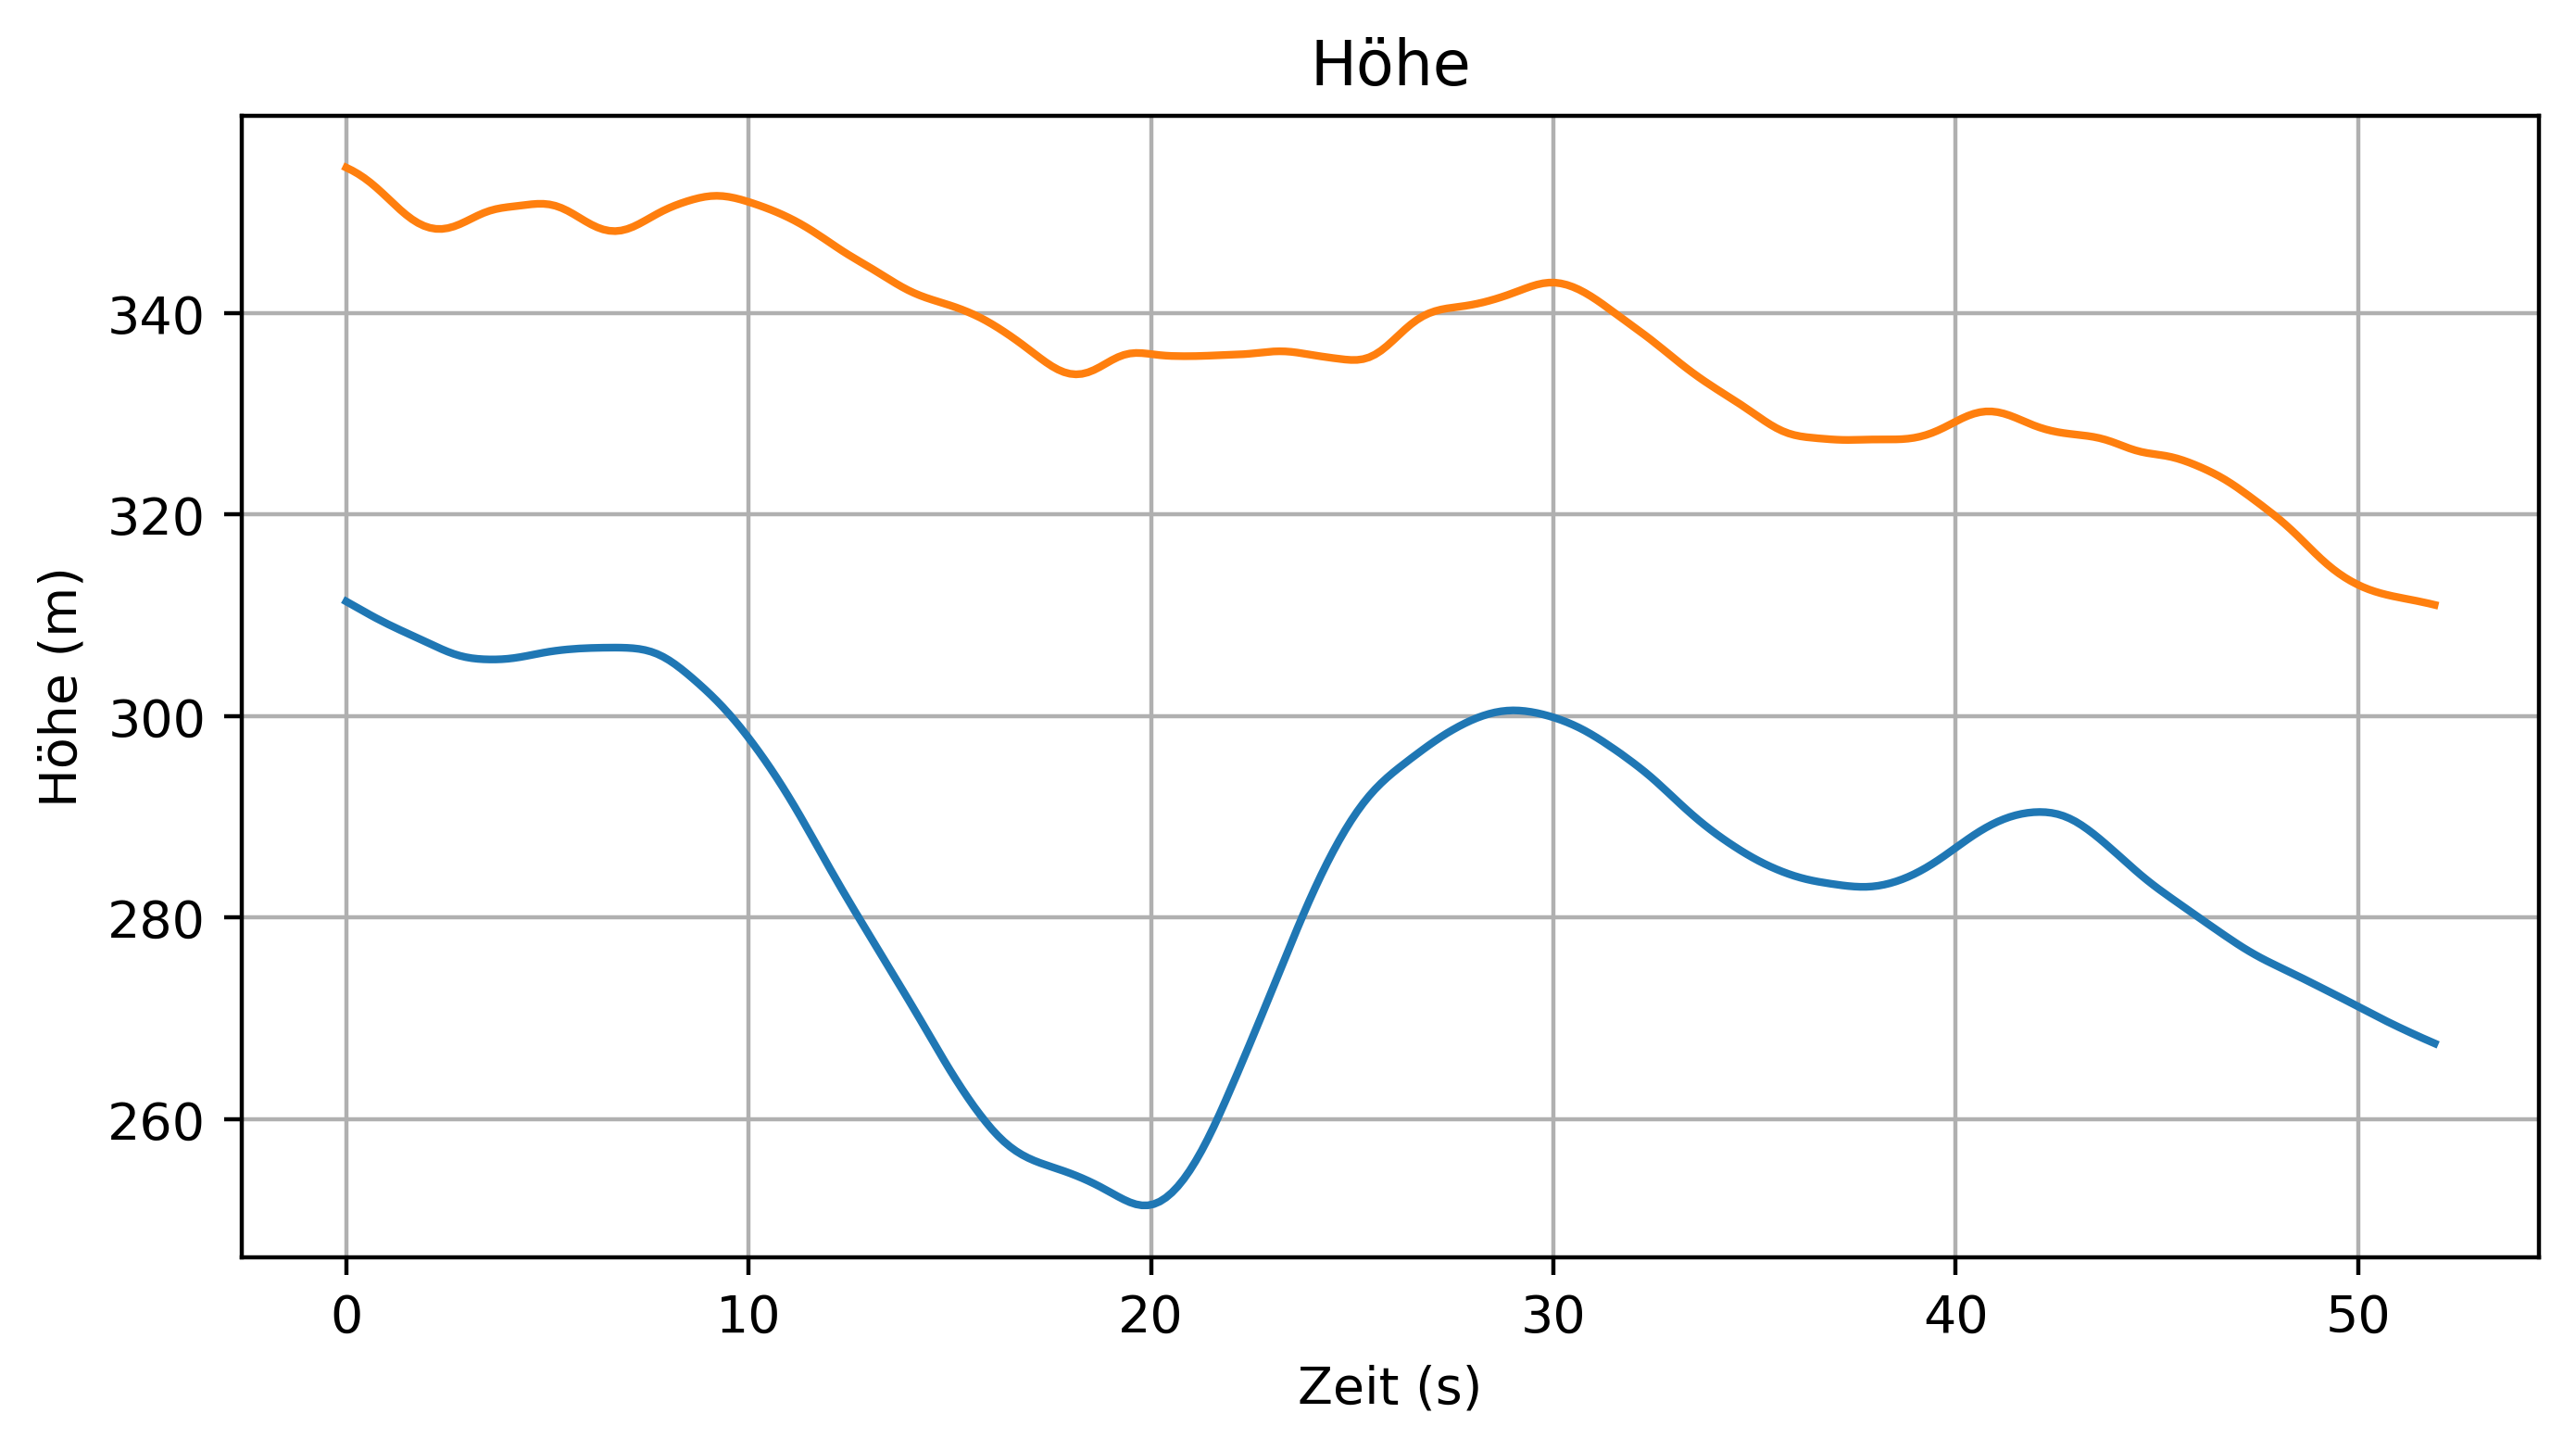

In [15]:
def calc_altiduide(p_list, QNH=1013.25, rho=1.225, h_0 = 0):
    result  = []
    for p in p_list:
        result.append(44330.77*(1-(p/QNH)**(1/5.255)) - h_0)
    return result

h_static = calc_altiduide(static,QNH=1010.6, h_0=250)
h_tek = calc_altiduide(tek,QNH=1010.6,h_0=250)


description = {
    "title": "Höhe",
    "xLable": "Zeit (s)",
    "yLable": "Höhe (m)"
}
plt_data(time, (h_static, h_tek), description=description, borders = (lower, upper), zerotime = True)

Staudruck vom Sensor und aus Differenz von TEK und statischem Druck berechnen

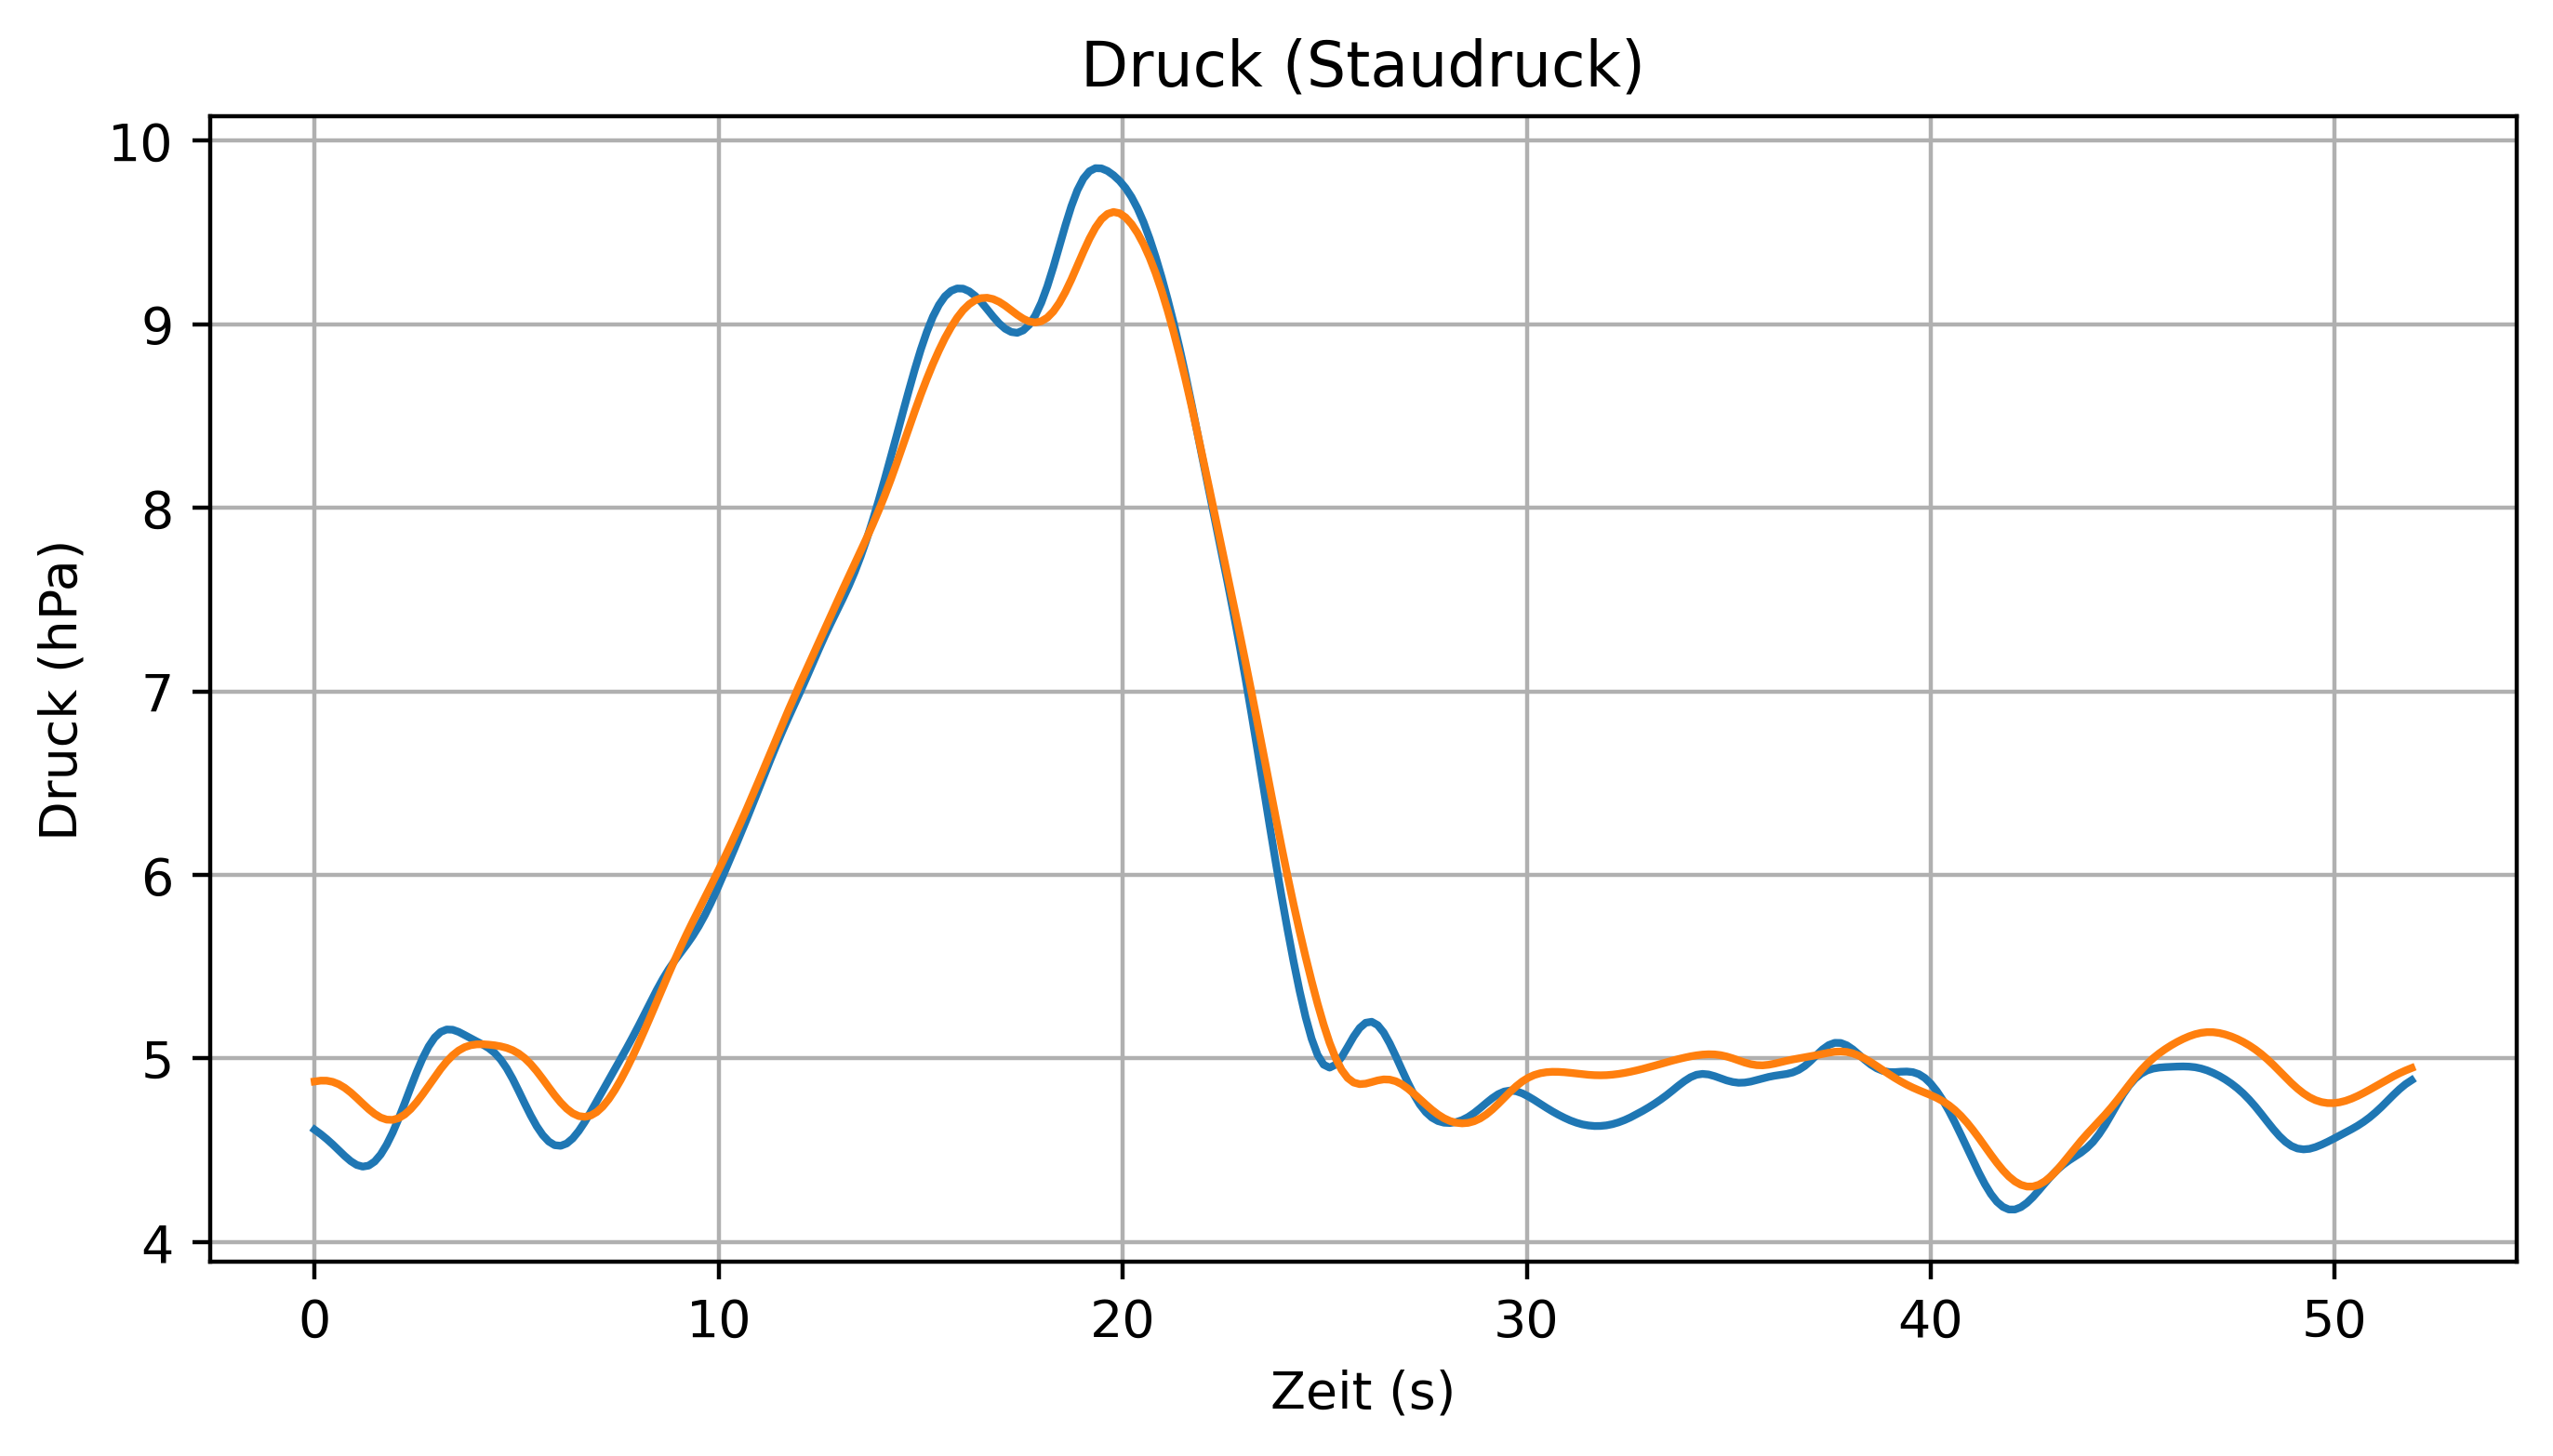

In [16]:
d_stek = []
for t, stat, staupoint in zip(tek,static, stau):
    d_stek.append((stat-t))

ams_correction = 4.85 #Faktor um die Daten des AMS Sensors zu korrigieren
stau = [s*ams_correction for s in stau]

stau = smoothListGaussian(stau, 10)

description = {
    "title": "Druck (Staudruck)",
    "xLable": "Zeit (s)",
    "yLable": "Druck (hPa)"
}
plt_data(time,(stau, d_stek), description=description, borders = (lower, upper), zerotime = True)

Aus den beiden Staudrücken die Geschwindigkeit berechnen

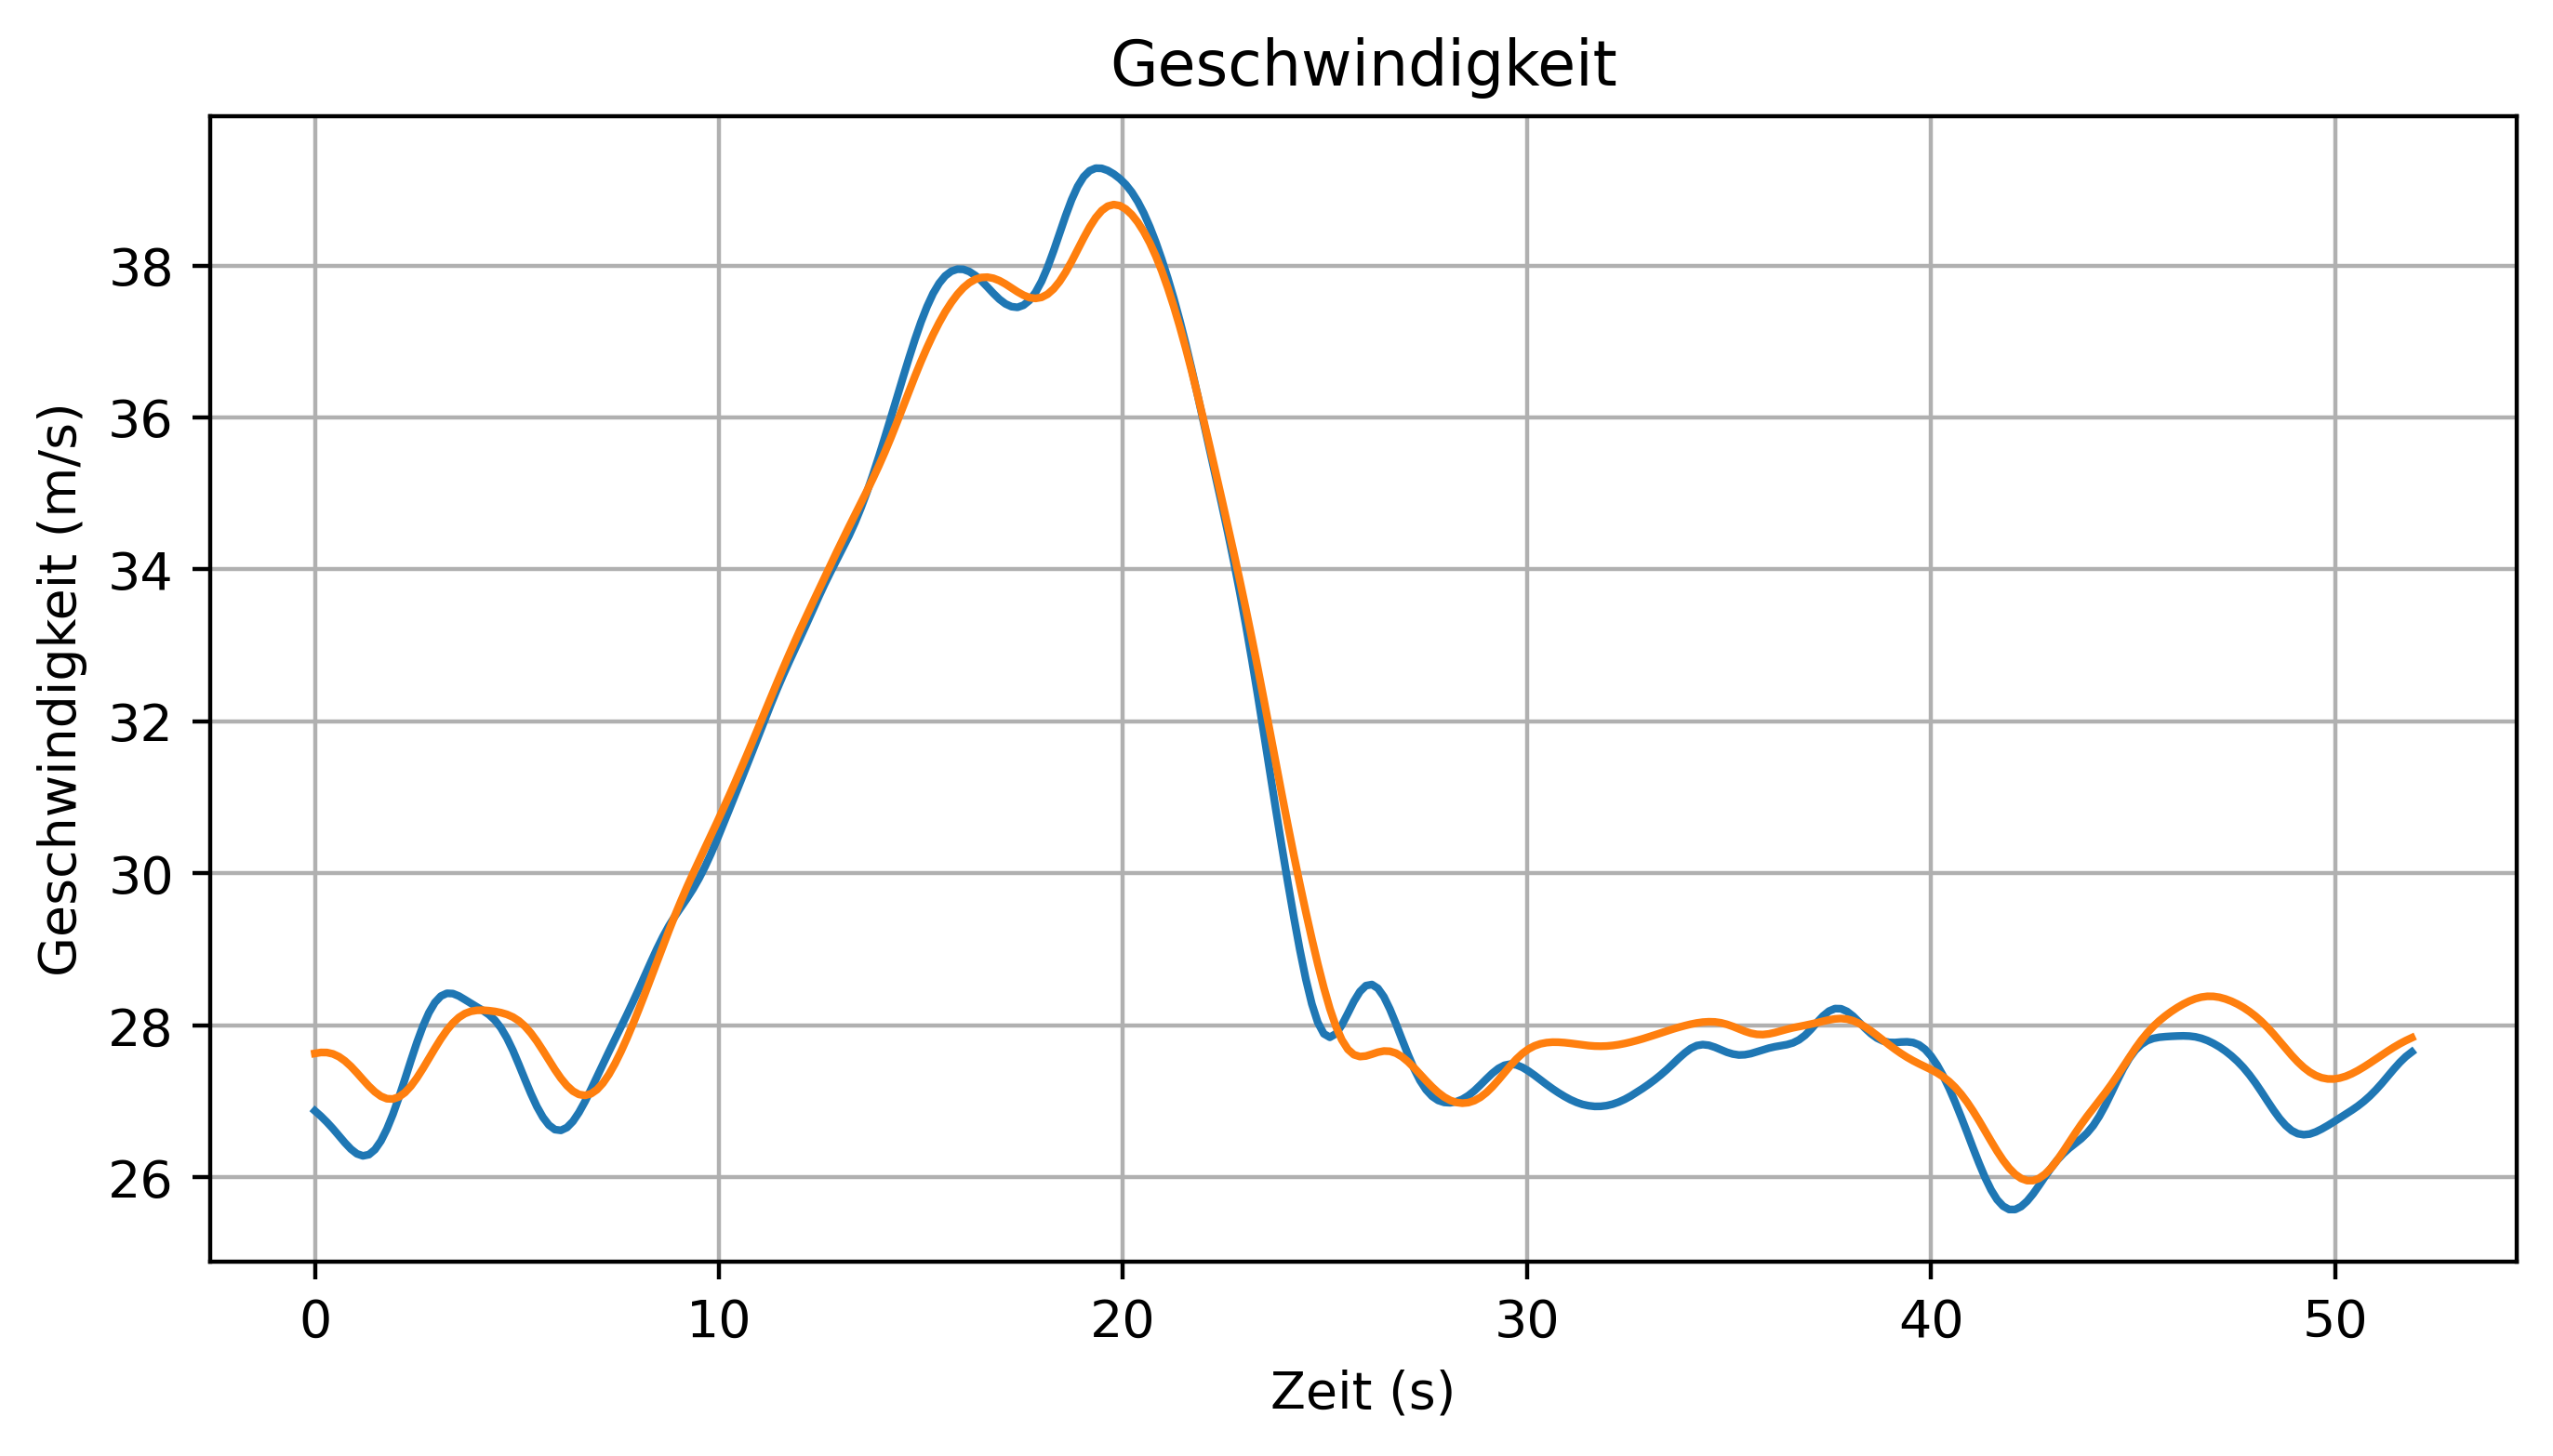

In [17]:
vstau = []
vtek = []
rho = 1.13 #Luftdichte
for t, stat, staupoint in zip(tek,static, stau):
    d_stek.append((stat-t))

    if staupoint <= 0:
        vstau.append(0)
    else:
        vstau.append((sqrt( (200*(staupoint))) /rho))
    vtek.append( (sqrt(  (200*(stat-t))) /rho) )
    
description = {
    "title": "Geschwindigkeit",
    "xLable": "Zeit (s)",
    "yLable": "Geschwindigkeit (m/s)"
}
plt_data(time,(vstau, vtek), description=description, borders = (lower, upper), zerotime = True)

Eine Funktion die aus den Höhendaten eine Varioanzeige berechnet

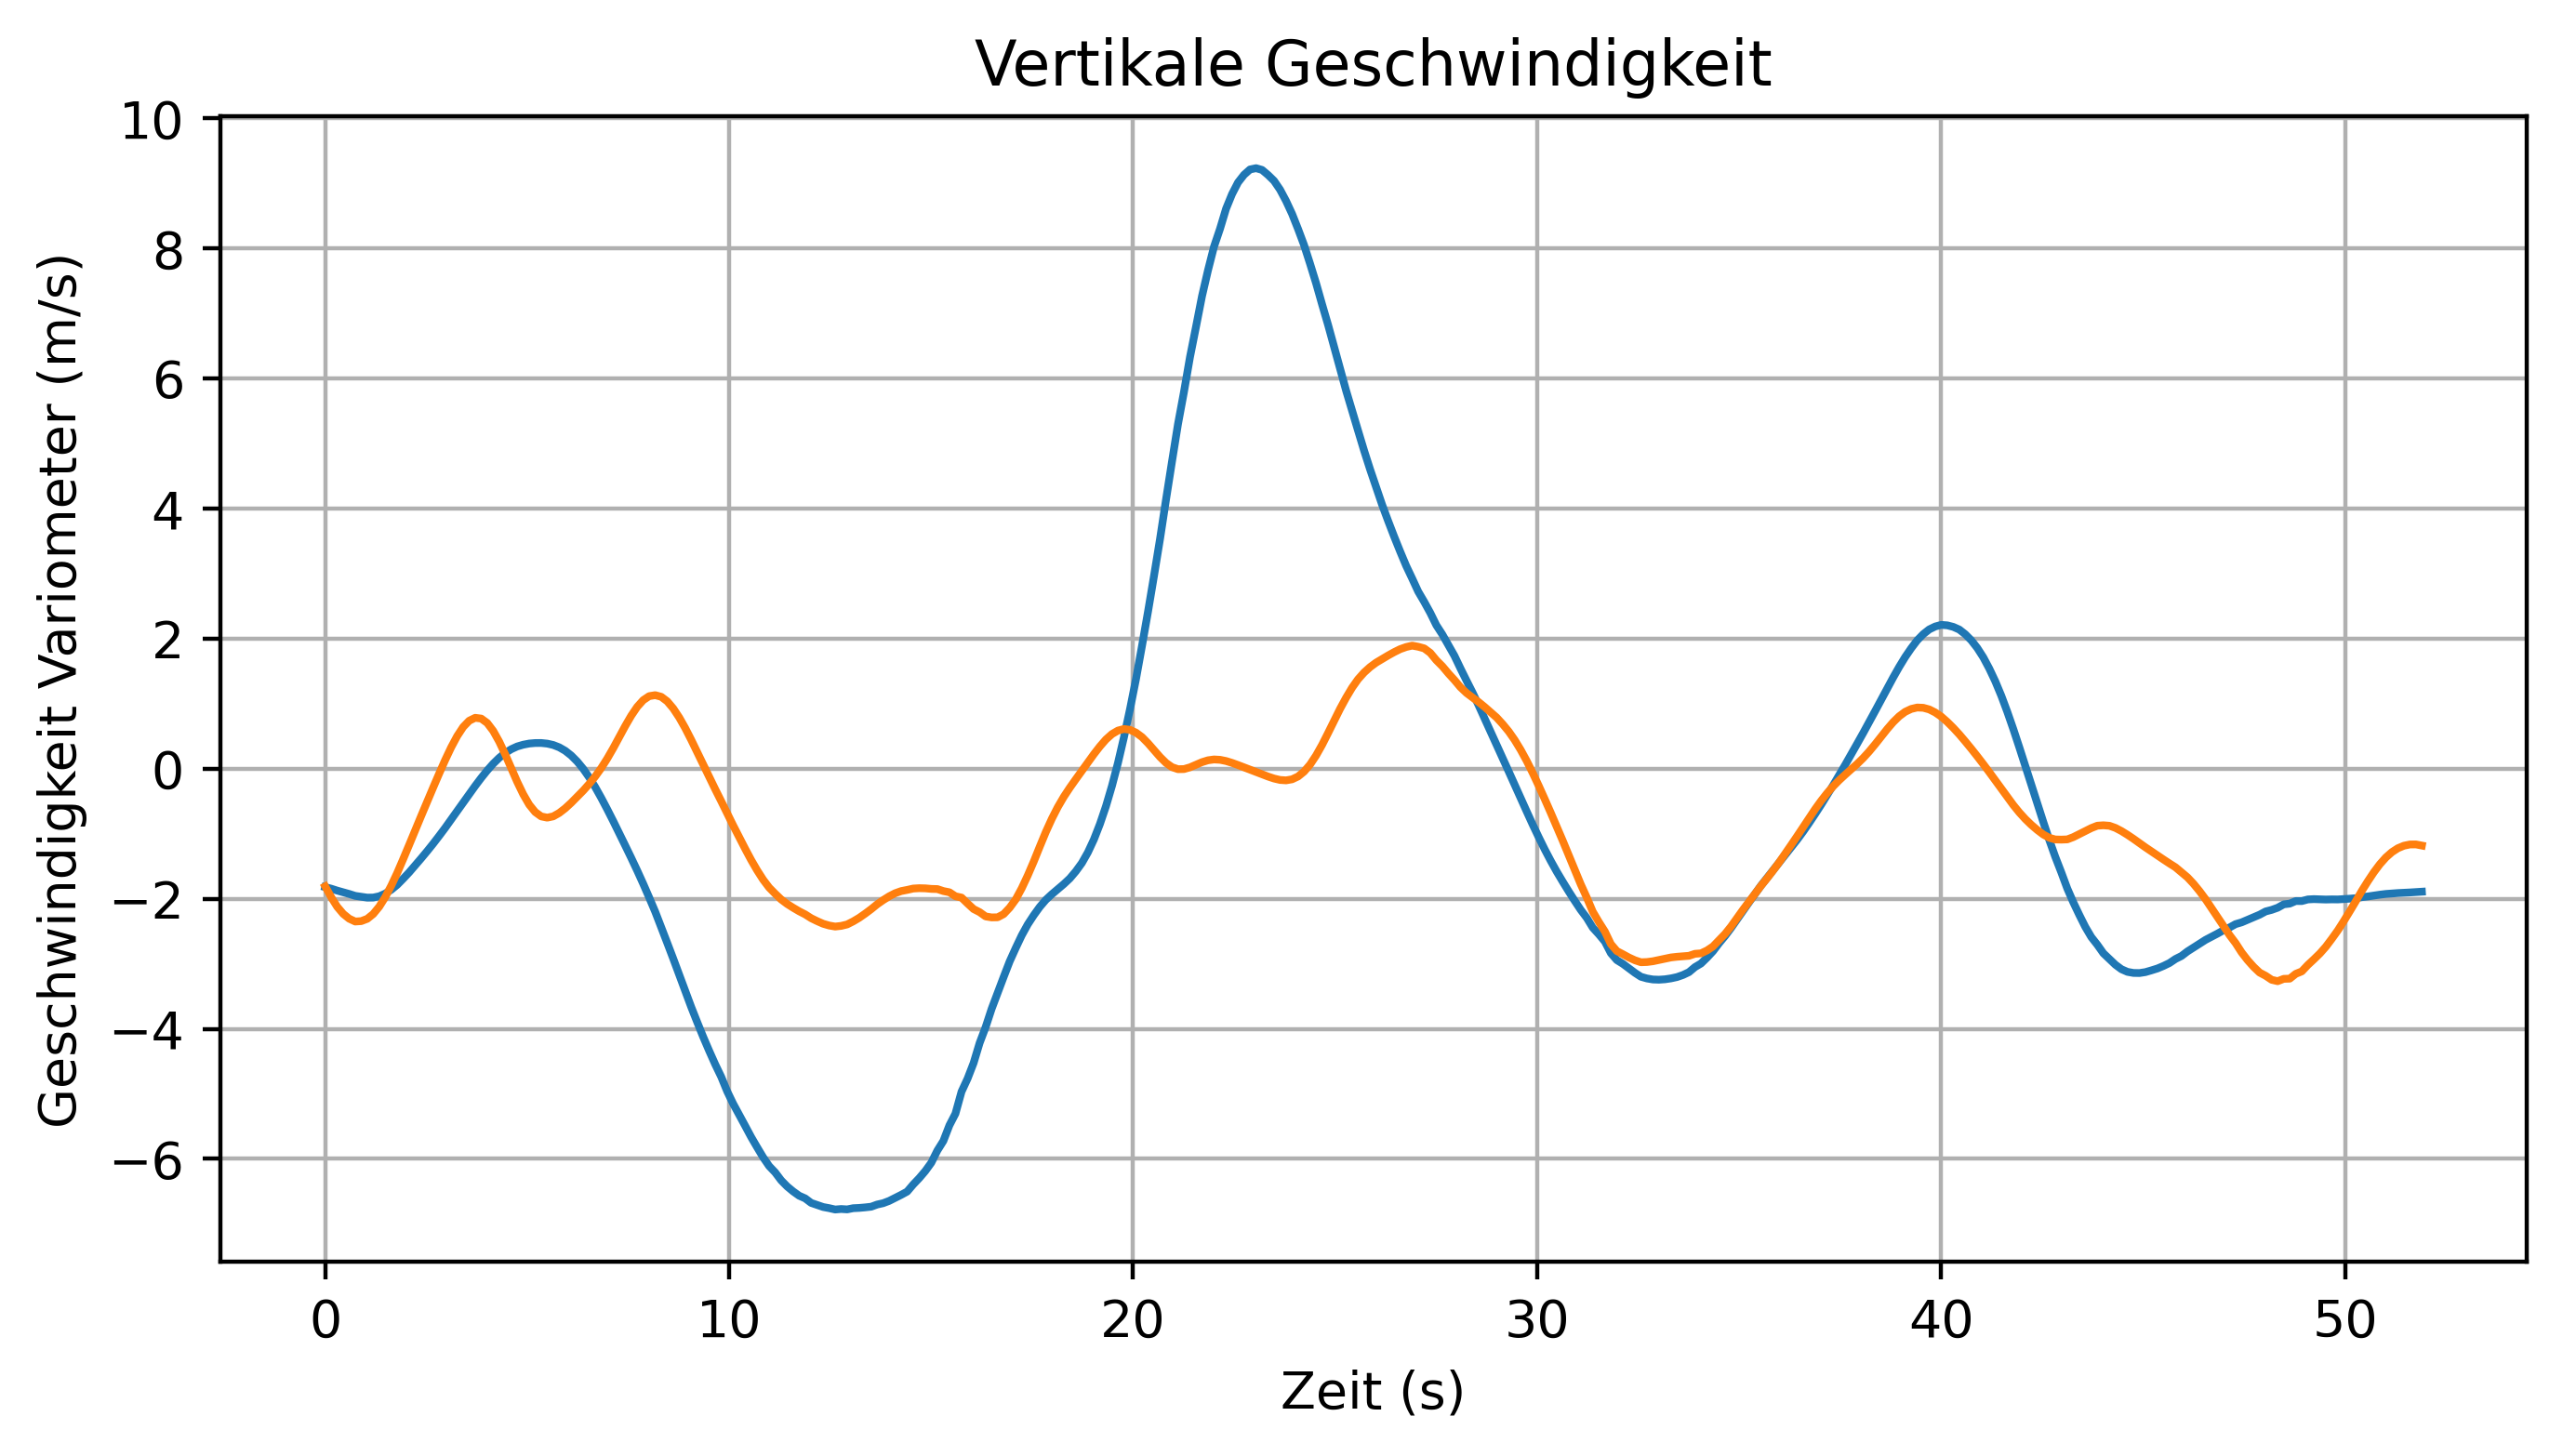

In [18]:
def calc_v_vario(t_list, h_list): 
    v_vario = []
    avg = 10

    i = 0
    for h,t in zip( h_list, t_list):
        if i == 0: 
            i+=1 
            continue
        
        try: 
            h = sum(h_list[i-avg:i+avg]) / len(h_list[i-avg:i+avg])
            h_last =sum(h_list[i-avg-1:i+avg-1]) / len(h_list[i-avg-1:i+avg-1])
        except:
            h_last = h_list[i-1]
        
        t_last = t_list[i-1]

        v_vario.append((h - h_last) / (t-t_last))
        if i == 1: 
            v_vario.append((h - h_last) / (t-t_last))
        i+=1

    return v_vario

v_vario_static = calc_v_vario(time,h_static)
v_vario_tek = calc_v_vario(time,h_tek)

description = {
    "title": "Vertikale Geschwindigkeit",
    "xLable": "Zeit (s)",
    "yLable": "Geschwindigkeit Variometer (m/s)"
}
plt_data(time,(v_vario_static, v_vario_tek), description=description, borders = (lower, upper), zerotime = True)

Eine Funktion die die Druckdaten (ohne Düse) kompensiert

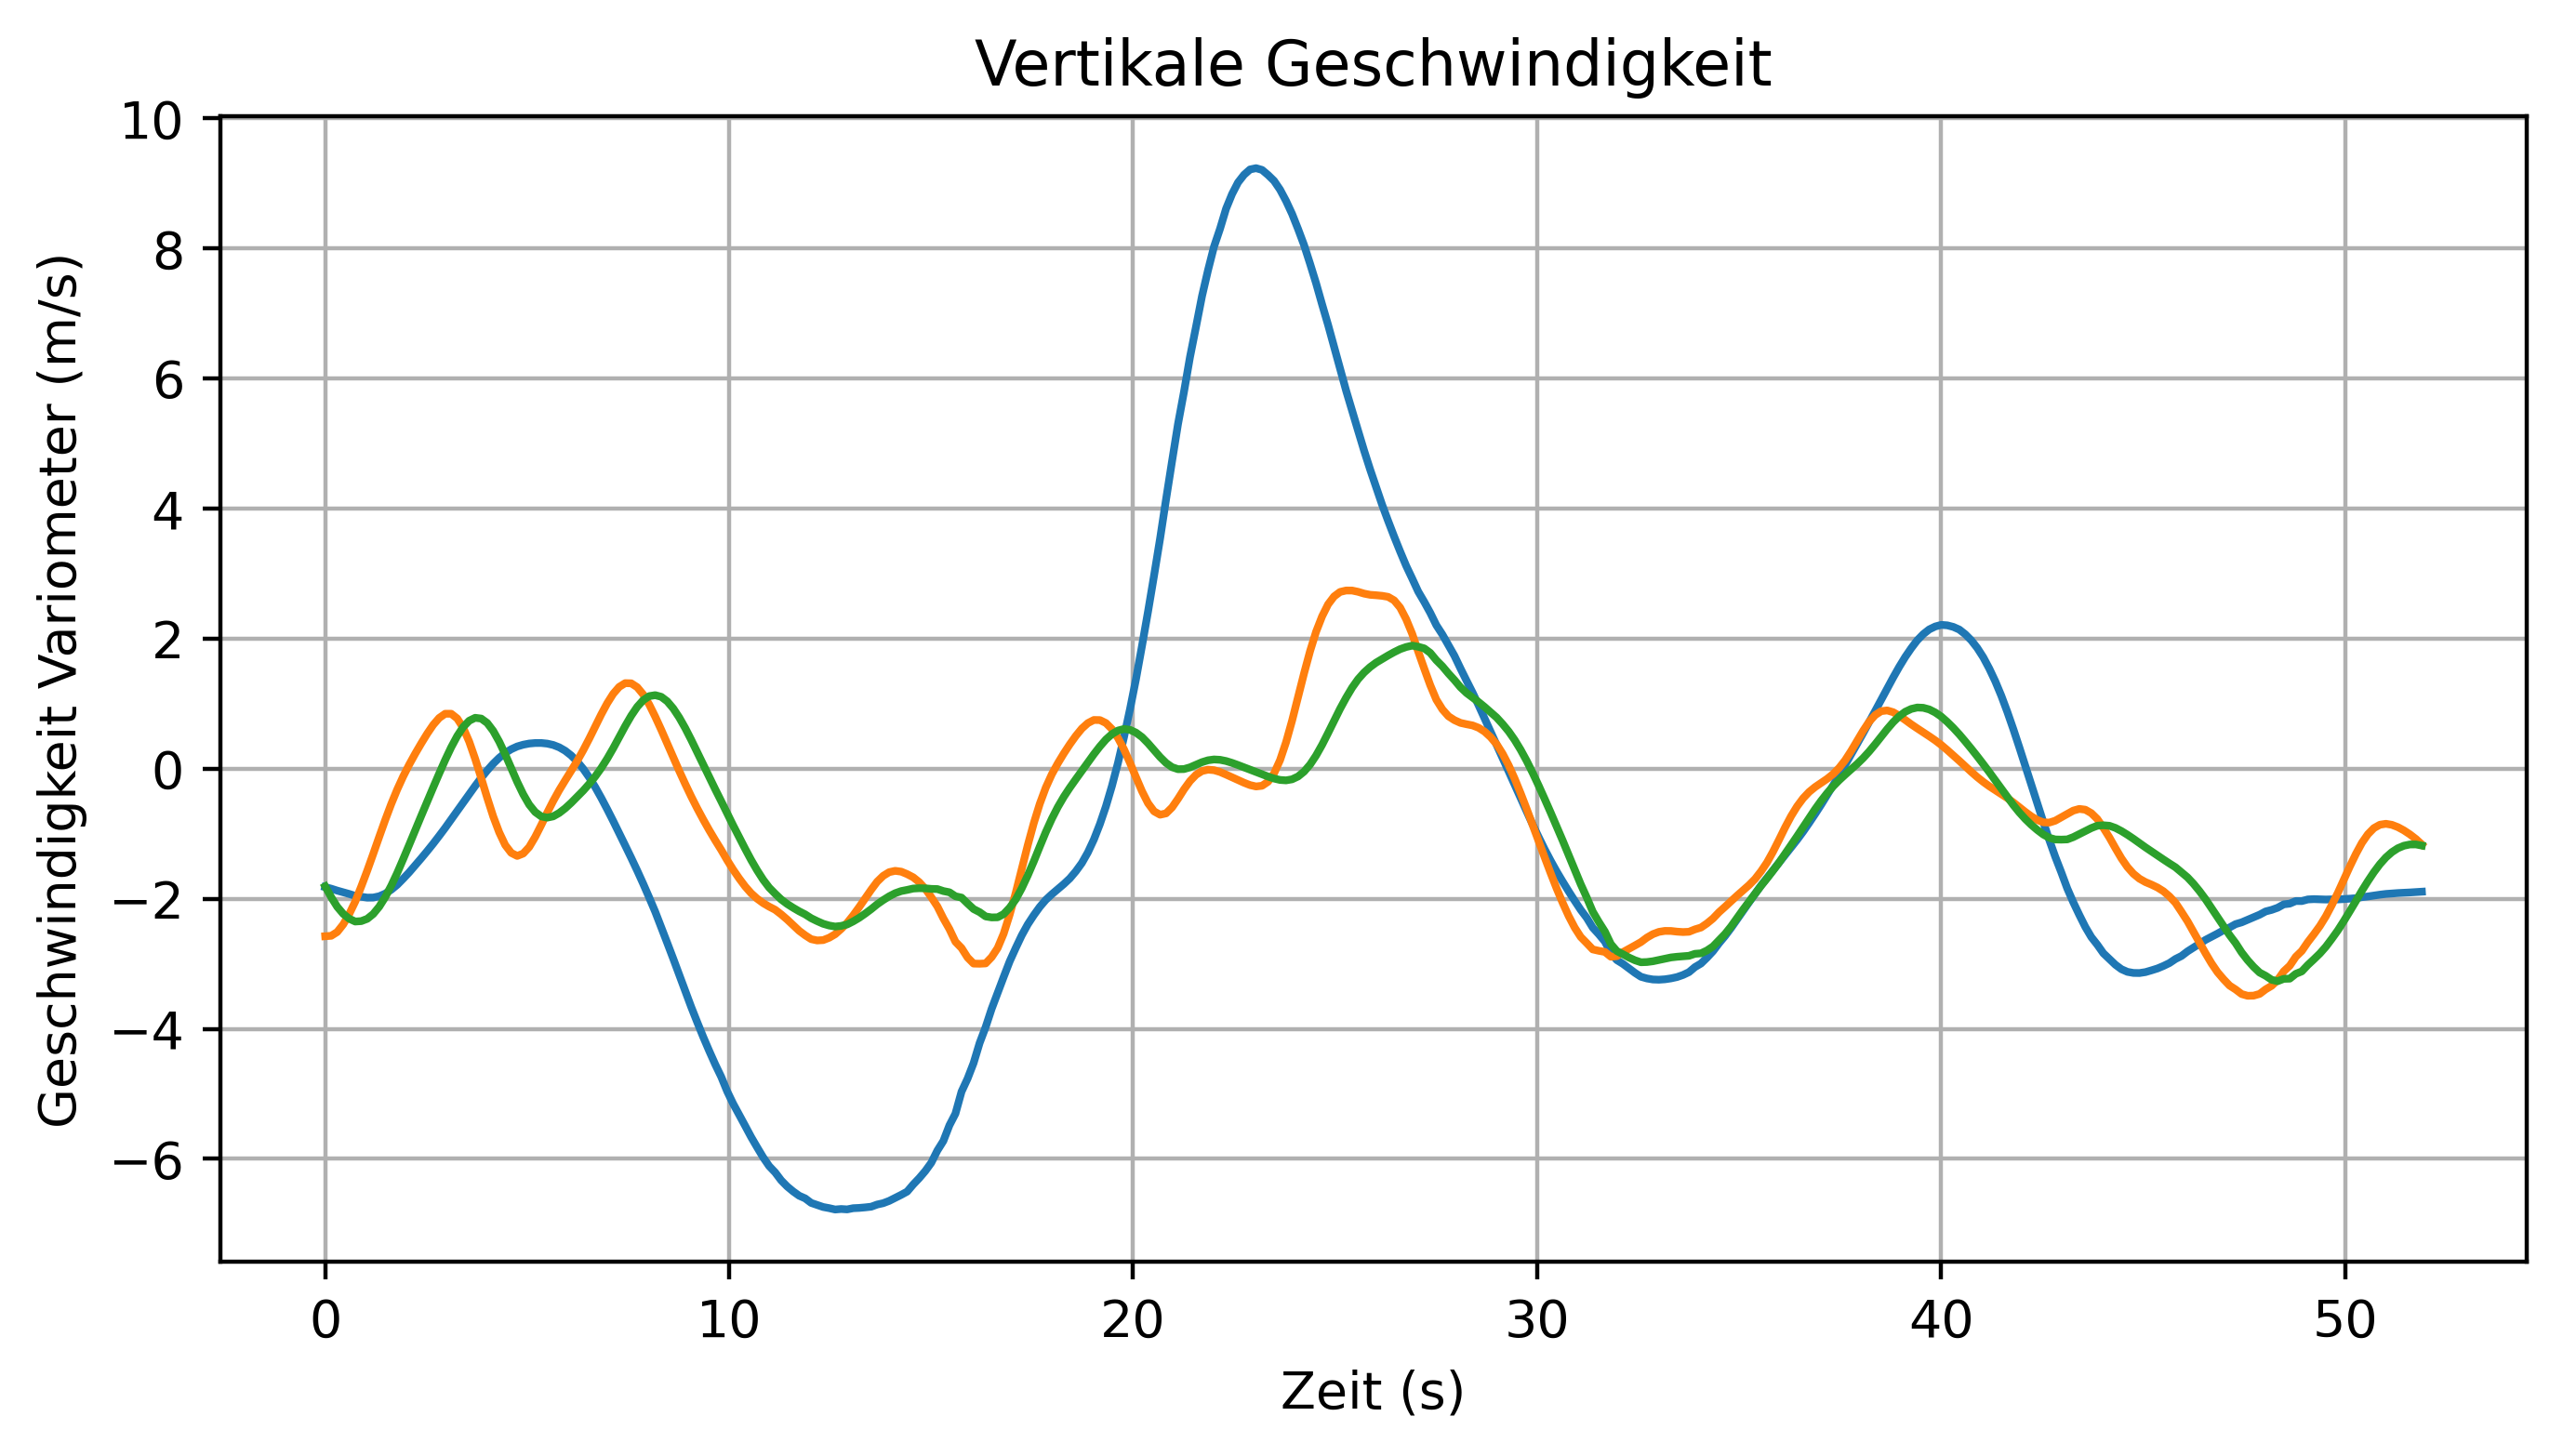

In [19]:
def compensate(t_list,v_list,h_list): 
    g = 9.81
    v_vario = []
    avg = 10
    i = 0

    for v, h, t in zip(v_list, h_list, t_list):
        if i == 0: 
            i+=1 
            continue
        
        try: 
            v = sum(v_list[i-avg:i+avg]) / len(v_list[i-avg:i+avg])
            h = sum(h_list[i-avg:i+avg]) / len(h_list[i-avg:i+avg])
            v_last =  sum(v_list[i-avg-1:i+avg-1]) / len(v_list[i-avg-1:i+avg-1])
            h_last =sum(h_list[i-avg-1:i+avg-1]) / len(h_list[i-avg-1:i+avg-1])
        except:
            v_last = v_list[i-1]
            h_last = h_list[i-1]
        t_last = t_list[i-1]

        h_E_last = h_last + (v_last**2) / (2*g)
        h_E = h + (v**2) / (2*g)
        v_vario.append((h_E - h_E_last) / (t-t_last))

        if i == 1: 
            v_vario.append((h_E - h_E_last) / (t-t_last))
        i+=1

    return v_vario

v_vario_stauTEK = compensate(time,vstau,h_static)

plt_data(time,(v_vario_static, v_vario_stauTEK, v_vario_tek), description=description, borders = (lower, upper), zerotime = True)

## GPS

Höhe darstellen

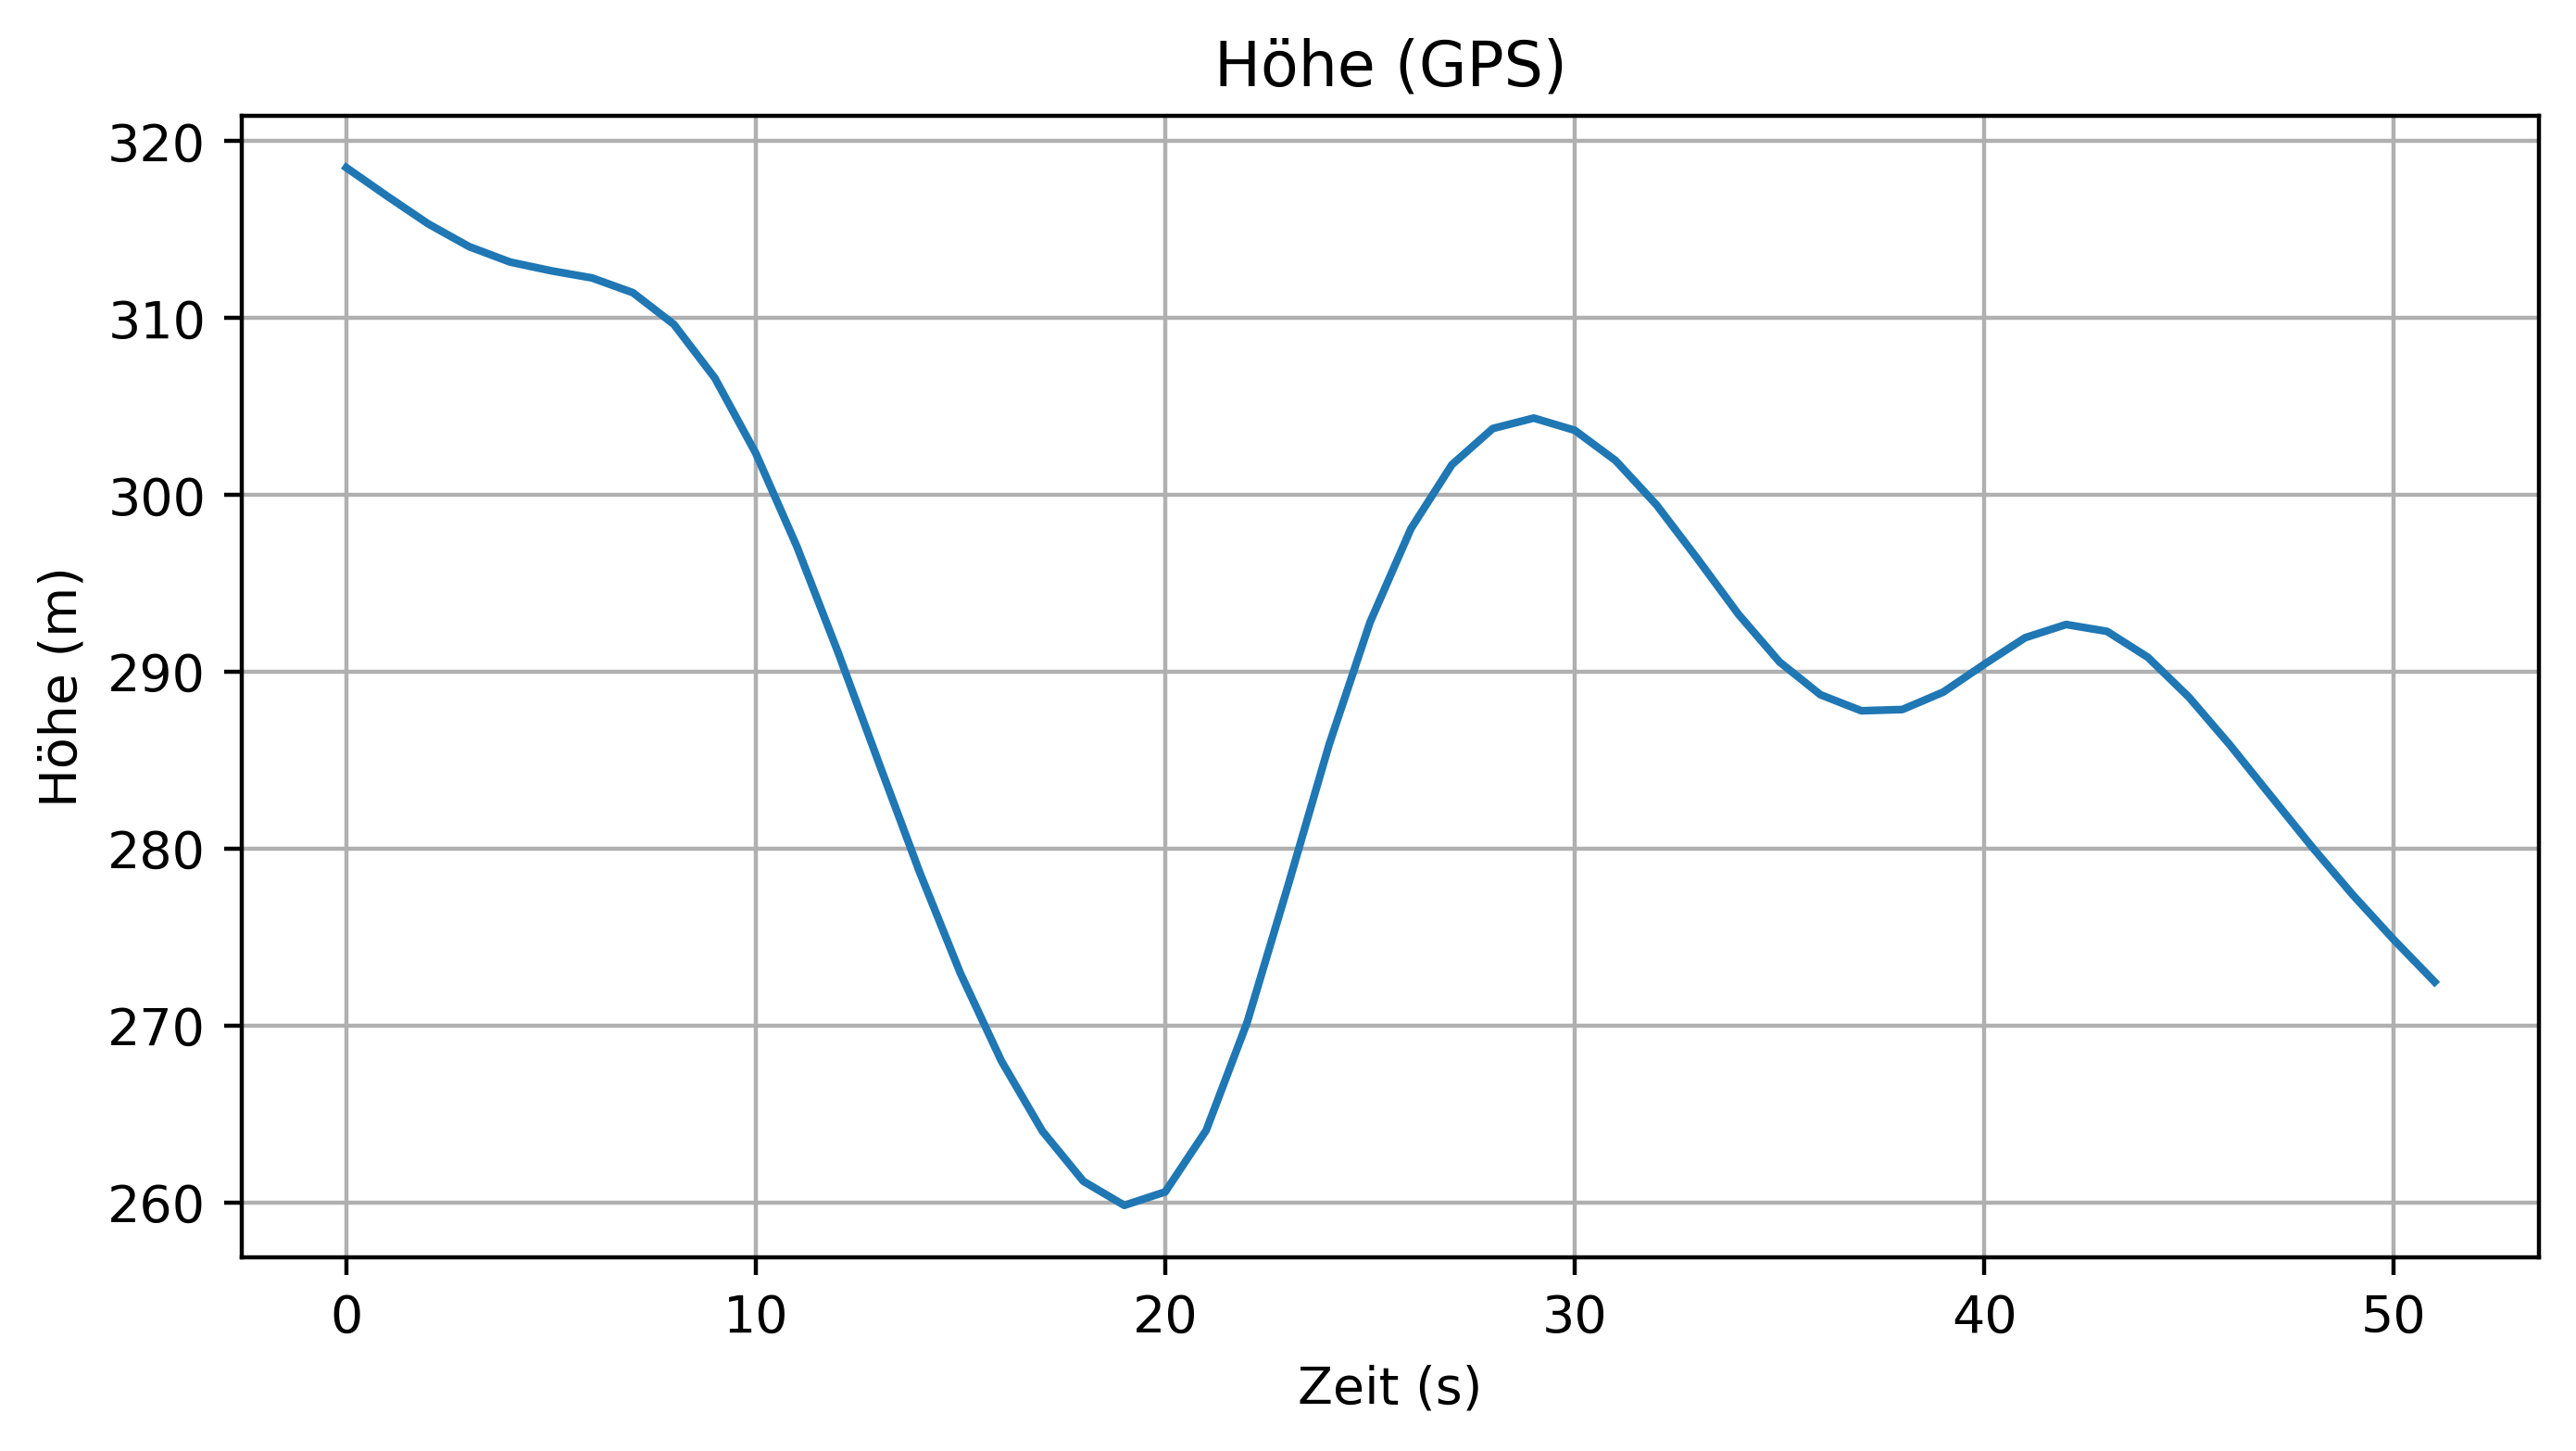

In [20]:
description = {
    "title": "Höhe (GPS)",
    "xLable": "Zeit (s)",
    "yLable": "Höhe (m)"
}
plt_data(time_gps,(altitude_gps), description=description, borders = (lower_gps, upper_gps), zerotime = True)


Geschwindigkeit darstellen

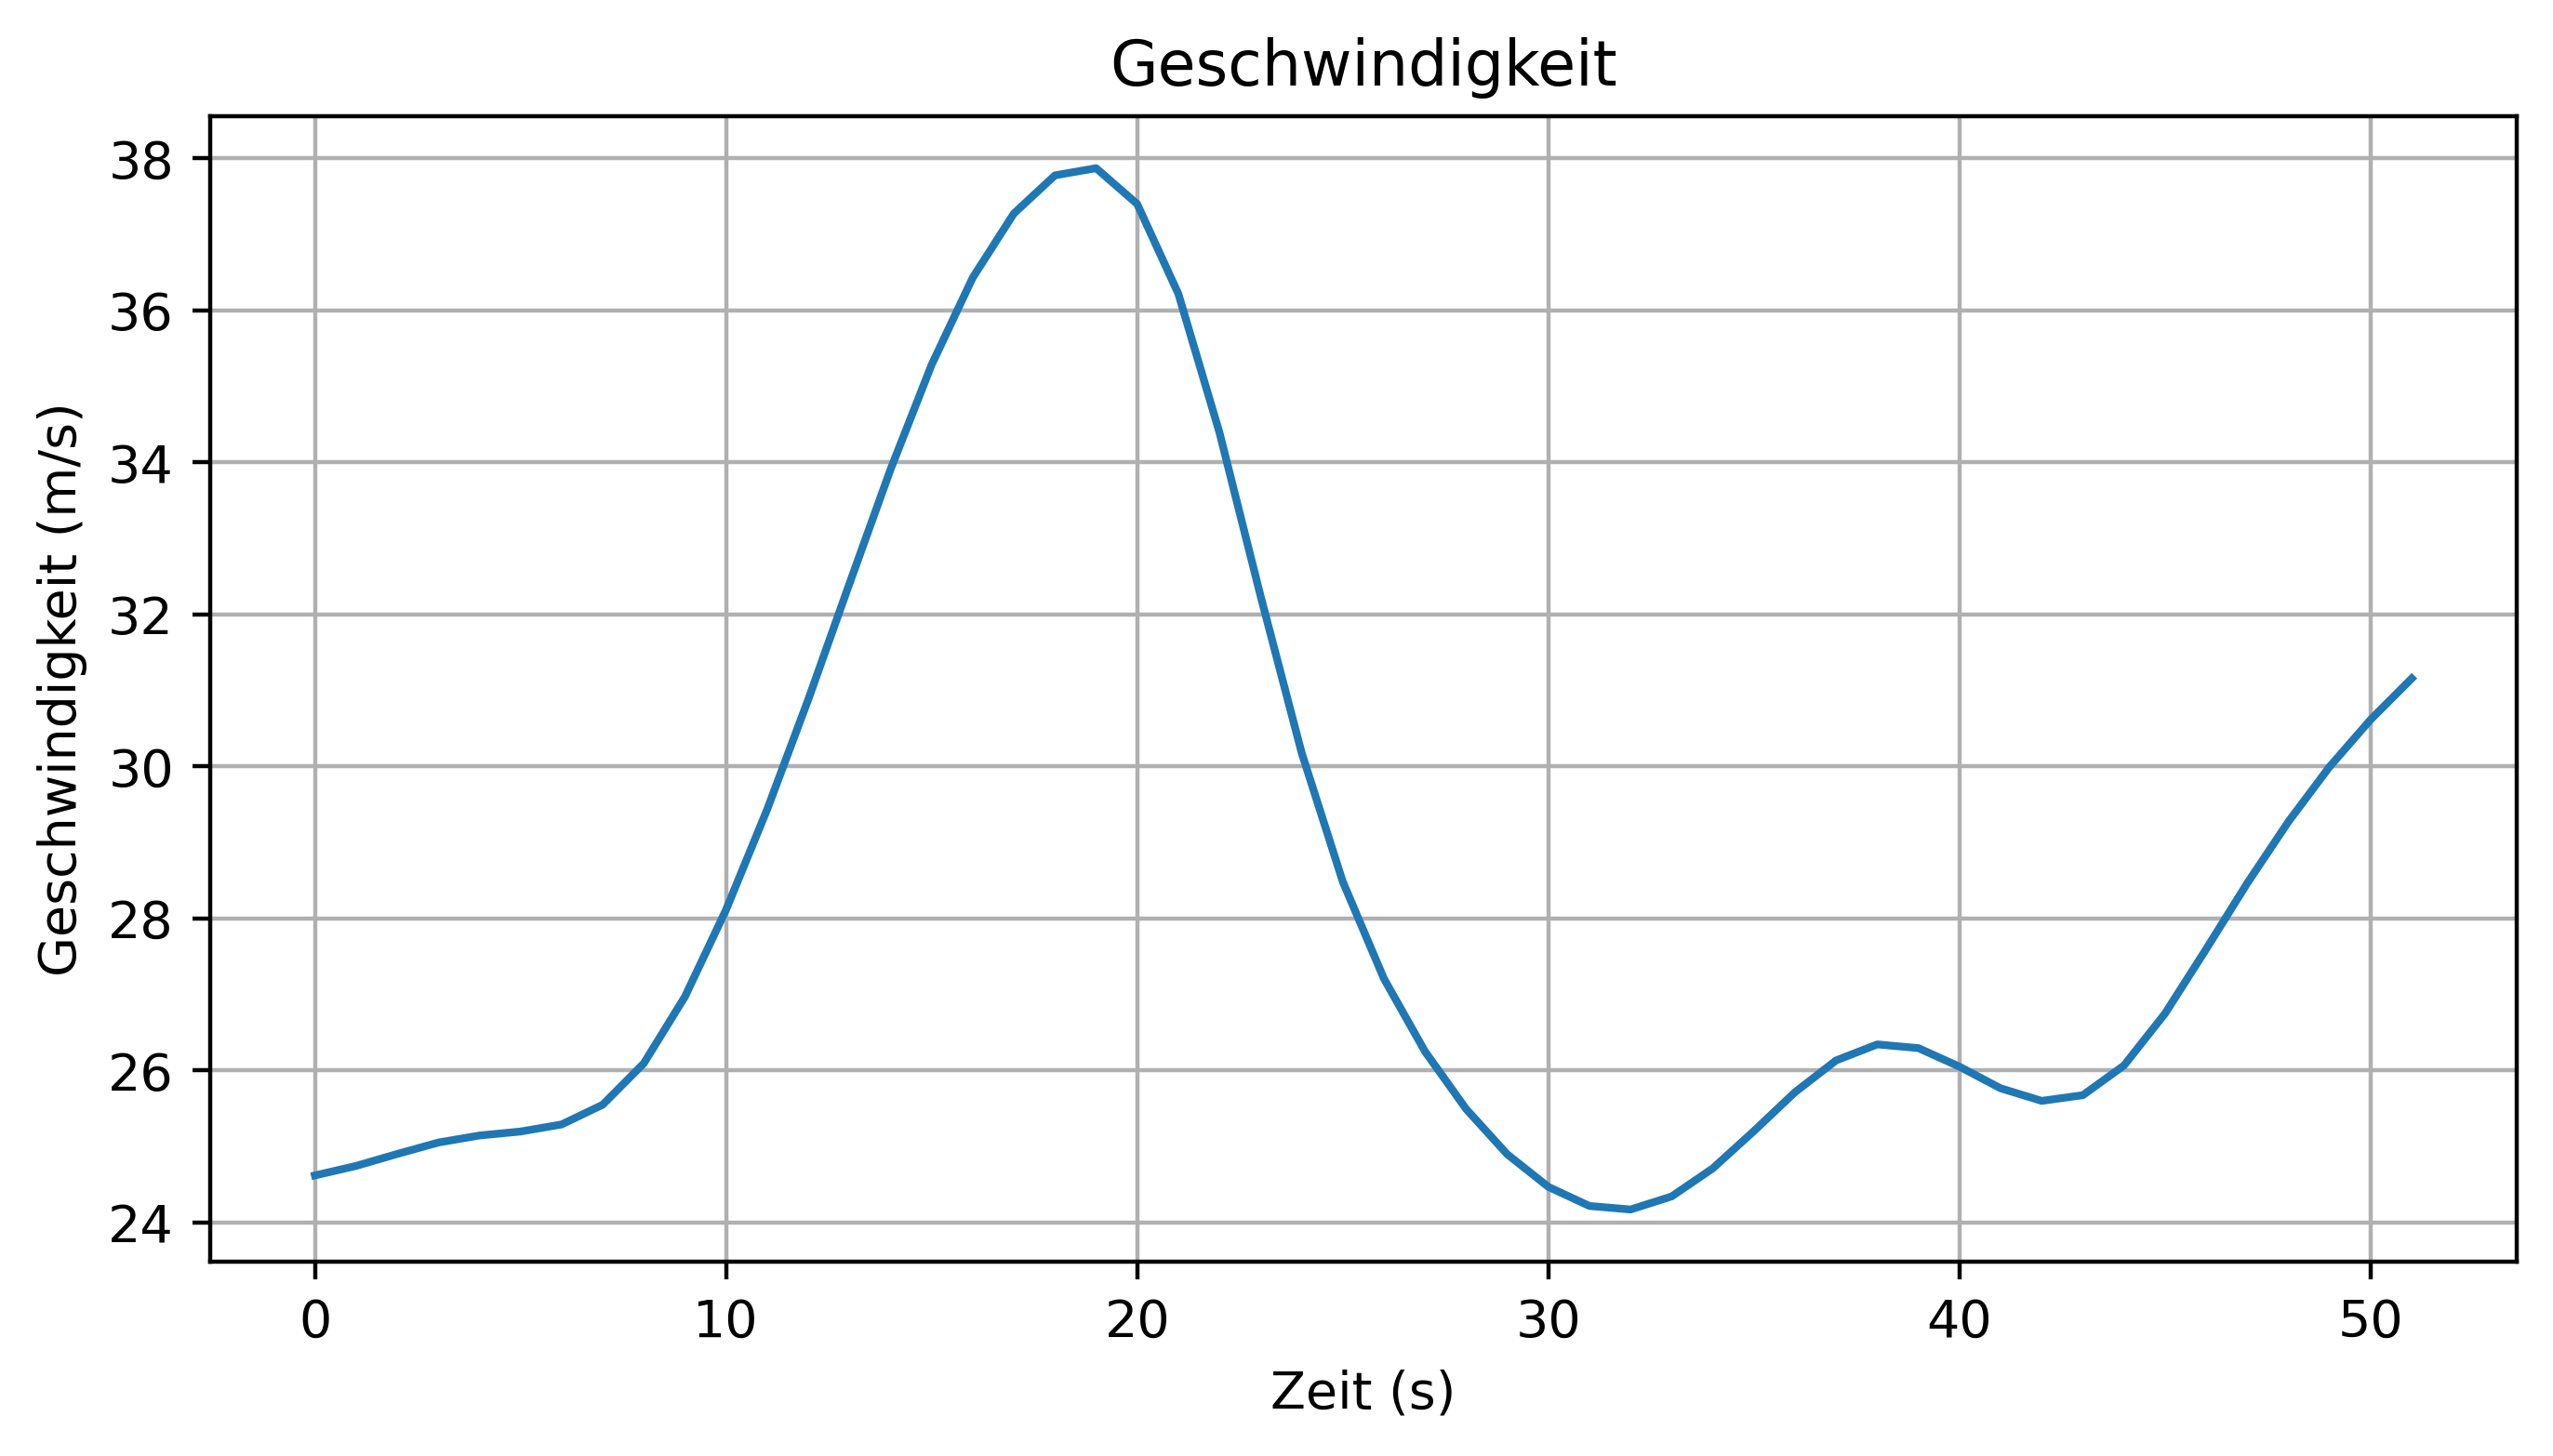

In [21]:
description = {
    "title": "Geschwindigkeit",
    "xLable": "Zeit (s)",
    "yLable": "Geschwindigkeit (m/s)"
}
plt_data(time_gps,(speed_gps), description=description, borders = (lower_gps, upper_gps), zerotime = True)

Eine Funktion, die aus der Höhe eine Varioanzeige erstellt

In [22]:
def calc_v_vario_gps(t_list, h_list): 
    v_vario = []

    i = 0
    for h,t in zip( h_list, t_list):
        if i == 0: 
            i+=1 
            continue
        
        t_last = t_list[i-1]
        h_last = h_list[i-1]

        v_vario.append((h - h_last) / (t-t_last))
        if i == 1: 
            v_vario.append((h - h_last) / (t-t_last))
        i+=1

    return v_vario


Eine Funktion, die aus der Höhe und der Geschwindigkeit eine kompensierte Varioanzeige erstellt

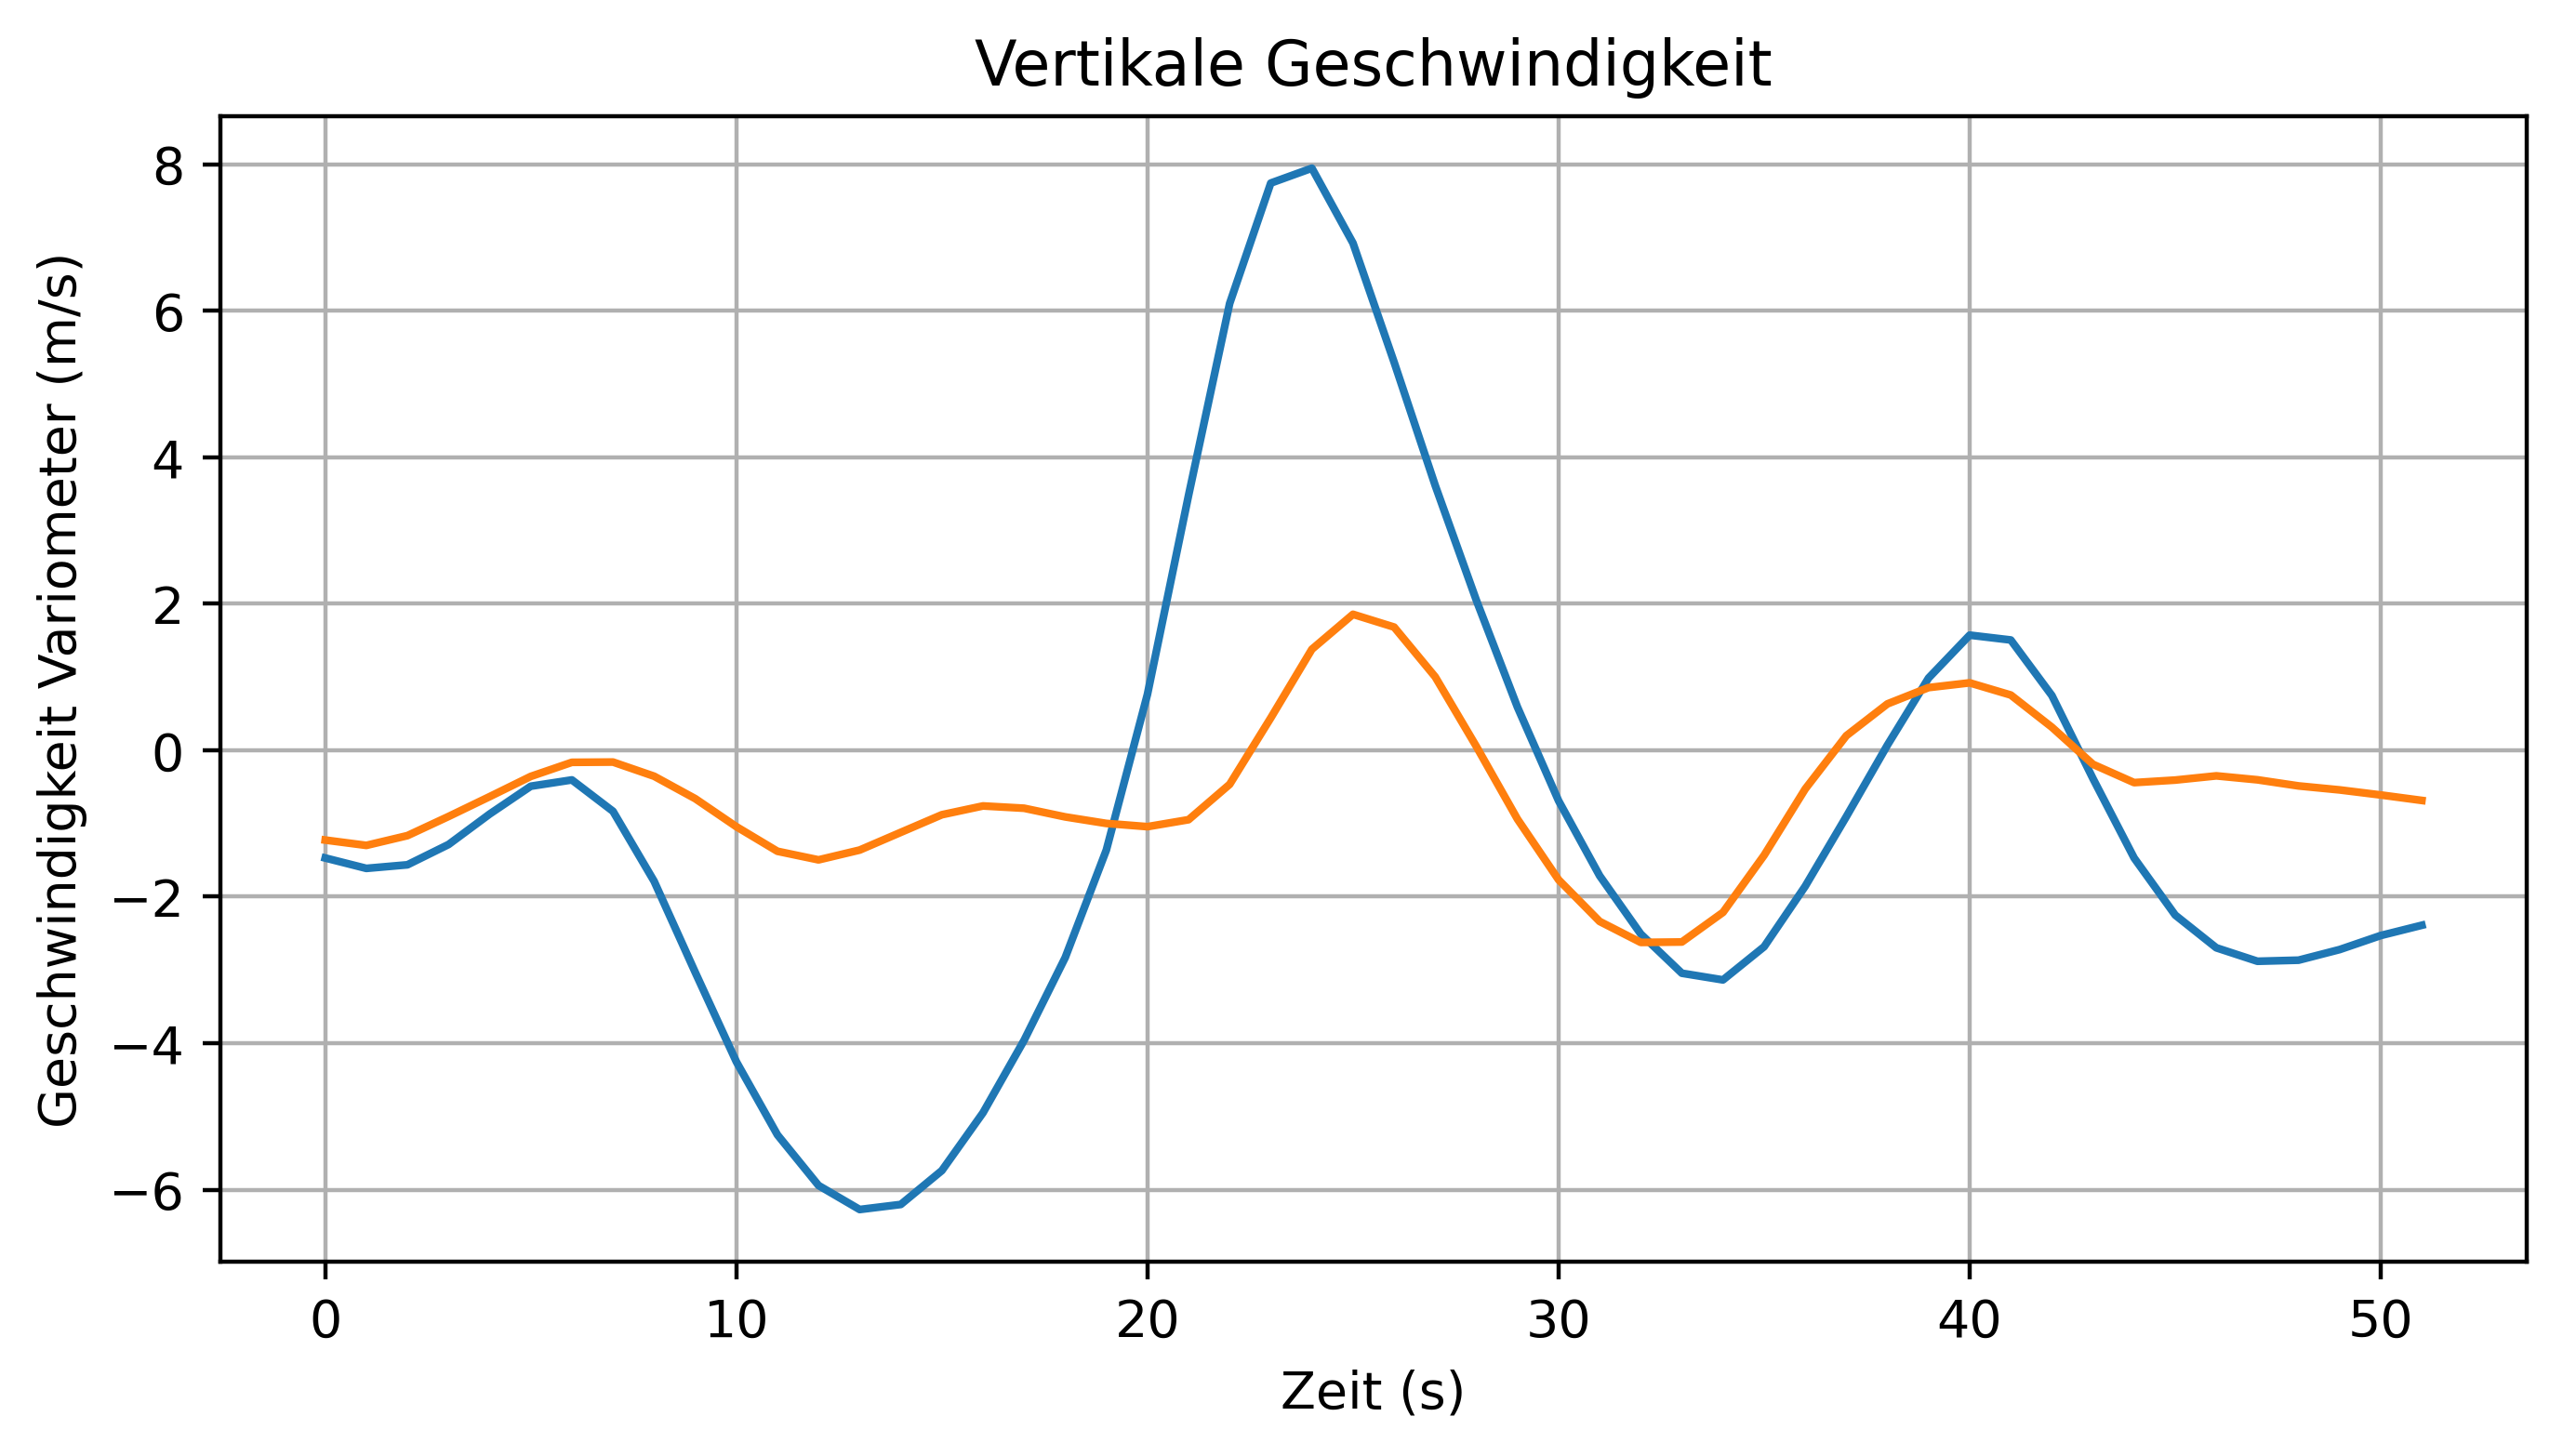

In [23]:
def compensate_gps(t_list,v_list,h_list): 
    g = 9.81
    v_vario = []

    i = 0
    for v, h, t in zip(v_list, h_list, t_list):
        if i == 0: 
            i+=1 
            continue
        
        t_last = t_list[i-1]
        v_last = v_list[i-1]
        h_last = h_list[i-1]

        h_E_last = h_last + (v_last**2) / (2*g)
        h_E = h + (v**2) / (2*g)
        v_vario.append((h_E - h_E_last) / (t-t_last))

        if i == 1: 
            v_vario.append((h_E - h_E_last) / (t-t_last))
        i+=1

    return v_vario

v_vario_gps = calc_v_vario_gps(time_gps, altitude_gps)
v_vario_tek_gps = compensate_gps(time_gps,speed_gps, altitude_gps)

description = {
    "title": "Vertikale Geschwindigkeit",
    "xLable": "Zeit (s)",
    "yLable": "Geschwindigkeit Variometer (m/s)"
}
plt_data(time_gps,(v_vario_gps, v_vario_tek_gps), description=description, borders = (lower_gps, upper_gps), zerotime = True)

## Auswertung

Alle Varionanzeigen in einem Diagramm darstellen

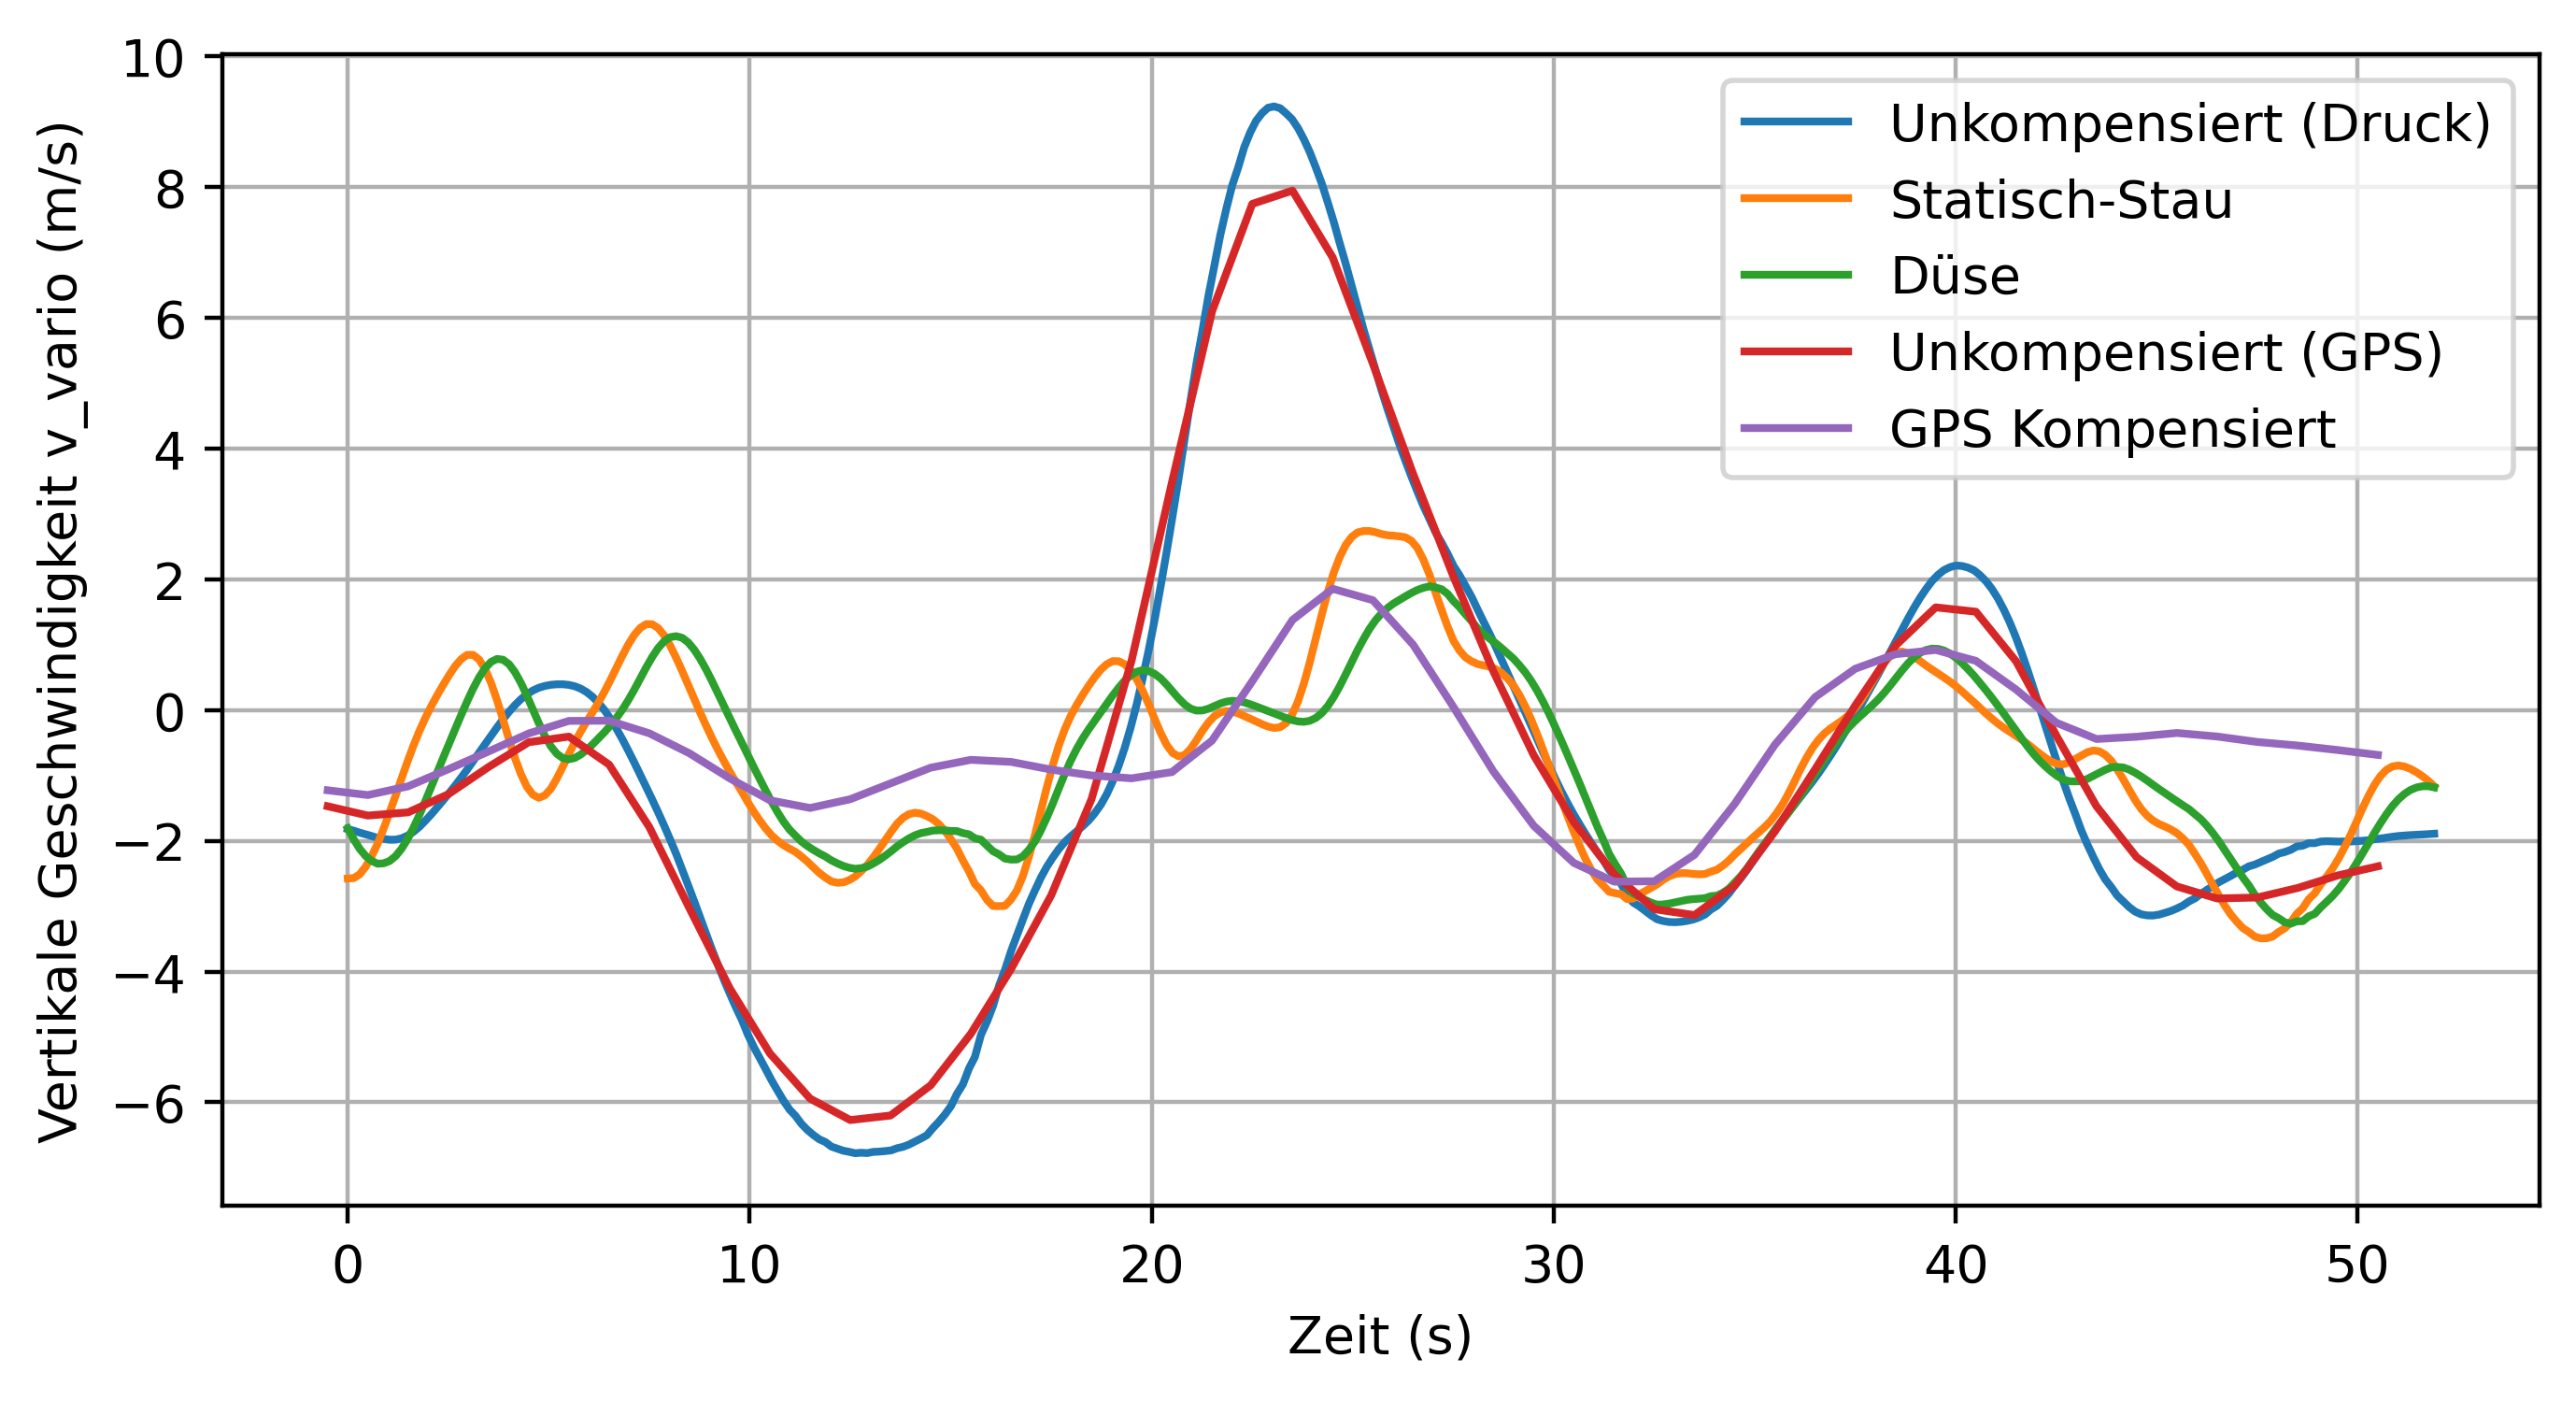

In [24]:
time0 = [t-time[lower] for t in time]
time_gps0 = [t-time_gps[lower_gps] -0.5 for t in time_gps]

plt.style.use('default')
fig, ax = plt.subplots(figsize=(8,4), dpi=400)

# Druck
ax.plot(time0[lower:upper], v_vario_static[lower:upper], label='Unkompensiert (Druck)')
ax.plot(time0[lower:upper], v_vario_stauTEK[lower:upper],  label='Statisch-Stau')
ax.plot(time0[lower:upper], v_vario_tek[lower:upper], label='Düse')

# GPS
ax.plot(time_gps0[lower_gps:upper_gps], v_vario_gps[lower_gps:upper_gps], label='Unkompensiert (GPS)')
ax.plot(time_gps0[lower_gps:upper_gps], v_vario_tek_gps[lower_gps:upper_gps], label='GPS Kompensiert')

# ax.set_title('Vergleich Kompensationsarten')
ax.set_xlabel('Zeit (s)')
ax.set_ylabel('Vertikale Geschwindigkeit v_vario (m/s)')
ax.legend()
ax.grid()

plt.show()